In [1]:
%load_ext autoreload
%autoreload 2
from importlib import reload

from collections import defaultdict

import numpy

import random
from matplotlib import pyplot as plt
from random import shuffle, choice, randint

import math
import keras
import tensorflow

from NN_utils import BigTable, WeightClip

import pickle
import zlib

def logistic(x, b,off):
    z = b*(x-off)
    return numpy.exp(z)/(1+numpy.exp(z))

def pr_to_spread(p, comps=1, as_A_and_D=True):
    per_comp_p = p**(1/(comps))
#     print("p         ", p)
#     print("per comp p", per_comp_p)
#     spread = -numpy.log((1.0/per_comp_p)-1.0)
    inv_sigmoid = lambda pr : ( -numpy.log((1/pr) -1) )
    spread = inv_sigmoid(per_comp_p)
#     print("spread    ", spread)
    if as_A_and_D:
        a = spread/2.0
        d = -spread/2.0
        return a,d
    else:
        return spread

print("started")


from sklearn.svm import SVR

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


started


In [2]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits):
    students = numpy.zeros((n_students, n_factors))
    for six in range(n_students):
#         true_comps = numpy.random.normal(a0, a1, size=n_factors)#+0.2#+2#+1.2
#         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
        true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
        for cix,c in zip(range(n_factors), true_comps):
            students[six,cix] = c

    questions = numpy.zeros((n_questions, n_factors))
    for qix in range(n_questions):
#         n_comps = randint(min_active_traits, max_active_traits)
        n_comps = n_factors
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)
        true_comps = numpy.random.uniform(a0[0],a0[1], size=n_comps)

        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c#+boost
    
    print("genqs",students.shape, questions.shape)
    return students, questions

def gen_bayes_run(n_traits, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_bayes_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits)
    print(students.shape, questions.shape)
    obs = numpy.zeros((len(students), len(questions)))
    probs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    for vi in range(len(students)):
        for mi in range(len(questions)):
            prs = (1-questions[mi]) + (questions[mi]*students[vi])
            pr = numpy.prod(prs)
            obs[vi,mi] = (random.random() < pr)
            probs[vi,mi] = pr
    return obs, probs, students, questions

# n_students, n_questions, n_factors, min_active, max_active = 100,100,10,10,10

In [3]:
from numpy.random import uniform, random_integers
from scipy.stats import truncnorm

def gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w):
    students = numpy.zeros((n_students, n_factors))
#     for six in range(n_students):
#         true_comps = numpy.random.normal(0, a1, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.normal(0, 5/3, size=n_factors)#+0.2#+2#+1.2
# #         true_comps = numpy.random.uniform(0,1, size=n_factors)#+0.2#+2#+1.2
#         for cix,c in zip(range(n_factors), true_comps):
#             students[six,cix] = c

    students = numpy.random.normal(0, a1, size=(n_students,n_factors))
            
    av_c = (min_active_traits + max_active_traits)/2
    d50 = pr_to_spread(.5, av_c, as_A_and_D=False)
    
    questions = numpy.zeros((n_questions, n_factors)) - 10
    
    minb=-(test_w/2) -a0 - d50
    maxb=(test_w/2) -a0 - d50
    questions = questions
    minb, maxb = sorted([minb, maxb])
    minb = float(minb)
    maxb = float(maxb)
    
    for qix in range(n_questions):
        n_comps = randint(min_active_traits, max_active_traits)
#         print("n_comps", n_comps)
        comp_ixs = numpy.random.choice(range(n_factors), size=n_comps, replace=False)  
#         print("range=", minb,maxb)
        true_comps = numpy.random.uniform(minb, maxb, size=n_comps)
        for cix,c in zip(comp_ixs,true_comps):
            questions[qix,cix] = c
            
    return students, questions


def calc_probs_from_embs(students,questions):
    students2 = numpy.repeat(students, len(questions), axis=0)
    questions2 = numpy.tile(questions, (len(students),1))
    zmask = numpy.isclose(questions2,-10).astype(int)
    diffs = students2-questions2
    prs = 1.0/(1.0+ numpy.exp(-diffs))
    prs = numpy.maximum(zmask,prs)
    probs2 = numpy.prod(prs, axis=1).reshape(len(students), len(questions))
    return probs2

def gen_rasch_run(n_factors, a0, a1, min_active_traits, max_active_traits, test_w=None, n_students=8, n_questions=8):
    students, questions = gen_rasch_students_questions(n_students, n_questions, a0, a1, n_factors, min_active_traits, max_active_traits, test_w=test_w)
    obs = numpy.zeros((len(students), len(questions)))
    vz = []
    mz = []
    scz =[]
    
#     students2 = numpy.repeat(students, n_questions, axis=0)
#     questions2 = numpy.tile(questions, (n_students,1))
    
# #     print("st and qn shapes:")
# #     print(students.shape)
# #     print(questions.shape)
    
#     zmask = numpy.isclose(questions2,-10).astype(int)
# #     print("zmask shape:", zmask.shape)
#     diffs = students2-questions2
# #     print("diffs shape:", diffs.shape)
#     prs = 1.0/(1.0+ numpy.exp(-diffs))
#     prs = numpy.maximum(zmask,prs)
#     probs2 = numpy.prod(prs, axis=1).reshape(n_students, n_questions)
        
    probs2 = calc_probs_from_embs(students, questions)
#     for vi in range(len(students)):
#         for mi in range(len(questions)):
#             zmask = numpy.isclose(questions[mi],-10).astype(int)
#             diffs = students[vi]-questions[mi]
#             prs = logistic(diffs,1,0)
#             prs = numpy.maximum(zmask,prs)

#             pr = numpy.prod(prs)
#             obs[vi,mi] = (random.random() < pr)
#             probs[vi,mi] = pr
            
    return obs, probs2, students, questions



In [28]:
# from scipy.stats import beta
# # n_questions = 100
# # n_students = 100
# # n_factors = 2

# def gen_run(n_movies, n_viewers, n_factors, min_active, max_active):
#     from numpy.random import randint, uniform

#     mina,maxa =(0,1)
#     minb,maxb =(0,1)
#     movies = randint(minb, maxb+1, size=(n_movies, n_factors))
#     viewers = randint(mina, maxa+1, size=(n_viewers, n_factors))
# #     movies =  beta.rvs(2, 2, size=(n_movies, n_factors))
# #     viewers = beta.rvs(2, 2, size=(n_movies, n_factors))

#     plt.hist(movies.flatten(), alpha=0.5)
#     plt.hist(viewers.flatten(), alpha=0.5)
#     plt.show()
    
#     print(movies)
#     print(viewers)

#     sig = lambda z : 1/(1+numpy.exp(-z))

#     obs = numpy.zeros((len(viewers), len(movies)))
#     #obs = numpy.matmul(viewers, movies.T)/n_factors
#     vz = []
#     mz = []
#     scz =[]
#     for vi in range(len(viewers)):
#         for mi in range(len(movies)):
# #             obs[vi,mi] = numpy.prod(sig(viewers[vi] - movies[mi]))
#             obs[vi,mi] = numpy.dot(viewers[vi], movies[mi])
# #             prxd = numpy.multiply(viewers[vi], movies[mi])
# #             obs[vi,mi] = numpy.sum(prxd)
# #             obs[vi,mi] = numpy.random.randint(0,2)
#             print(viewers[vi], movies[mi],"=",obs[vi,mi])
#     plt.hist(obs.flatten())
#     plt.show()
    
#     return obs, None, viewers, movies

In [29]:
# n_students, n_questions, n_factors, min_active, max_active = 100,150,100,1,5

# numpy.set_printoptions(precision=3)
# test_w = 5
# #rasch a0 = 3
# # a0 = 0.26 #bayes10
# a0 = (0.2,1)
# a1 = None
# # obs, probs, students, questions  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)
# obs, probs, students, questions  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w=test_w, n_students=n_students, n_questions=n_questions)

# plt.hist(students.flatten(), alpha=0.5)
# plt.hist(questions.flatten(), alpha=0.5)
# plt.show()

# plt.hist(probs.flatten())
# plt.show()

# plt.hist(obs.flatten())
# plt.show()

In [4]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Embedding, Flatten
from keras import backend as K, Model
def generate_qs_model(qn_table, psi_table, optimiser, _mode="MXFN", loss="MSE"):
    
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")

#     psi_row = Flatten(Embedding(psi_n, 100, input_length=1)(psi_sel))
#     qn_row = Flatten(Embedding(qn_n, 100, input_length=1)(qn_sel))
    
#     print(qn_table, psi_table, psi_sel, qn_sel)
#     print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

    print("Mode is", _mode)
    if _mode=="DEEP":
        difs = subtract([psi_row, qn_row])
        h = Dense(100, activation="relu")(difs)
        h = Dense(100, activation="relu")(h)
#         h = Dense(5, activation="relu")(h)
#         h = Dense(5, activation="relu")(h)
        score = Dense(1, activation="sigmoid")(h)        
    elif _mode=="COND":
        Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
#     elif _mode=="BINQ":
#         Prs = Lambda(lambda qs: (1 - qs[0])+(qs[0]*qs[1]), name="Prs")([qn_row, psi_row])
#         score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    elif _mode=="MLTM":
        klip = Lambda(lambda qk: K.clip(qk,-10, -9)+10)
        q_masque = klip(qn_row)
        difs = subtract([psi_row, qn_row])
        Prs = Lambda(lambda z: (1.0 / (1.0 + K.exp(-z))), name="Pr_sigmoid1")(difs)
        Prs = Lambda(lambda ps_q:  ps_q[0]*ps_q[1] + (1-ps_q[1]) ) ([Prs, q_masque])
        score = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="score")(Prs)
    else:
        if _mode!="MXFN":
            print("Invalid mode:", _mode, "- valid modes are COND, MLTM, MXFN (using default: MXFN)")
        _mode=="MXFN"
        scores = Lambda(lambda qp: qp[0] * qp[1])([qn_row, psi_row])
        score = Lambda(lambda s: K.sum(s, keepdims=True, axis=1), name="sum")(scores)
#         score = Lambda(lambda qp: K.batch_dot(qp[0], qp[1], axes=1), name="dot_prod")([qn_row, psi_row])
    #     score = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)))(score)
    
    model = Model(inputs=[qn_sel, psi_sel], outputs=score)

#     if _mode=="BINQ":
#         from_half = Lambda(lambda x: 1+K.sum((0.25-(x-0.5)**2)) )
#         s_loss = from_half(psi_table.kernel)
#         q_loss = from_half(qn_table.kernel)
#         def custom_loss(s_loss,q_loss):
#             def orig_loss(yt,yh):
#                 return K.binary_crossentropy(yt,yh) * s_loss * q_loss
# #             return K.mean(K.square(yt-yh)) + 5000*aux_av + 1000*aux_std + aux_loss/10000
#             return orig_loss
#         model.compile(optimizer=optimiser, loss=custom_loss(s_loss, q_loss), metrics=["accuracy"])
#         return model
    
    print("loss mode is", loss)
    if loss=="MSE":
        model.compile(optimizer=optimiser, loss="mse", metrics=["accuracy"])
    else:
        if loss!="XENT":
            print("loss mode must be MSE or XENT, not", loss," - setting to XENT.")
            loss="XENT"            
        model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])     
    print(model.summary())

    return model

In [5]:
from keras.regularizers import l1
from keras.layers import Dropout, multiply, subtract, GaussianNoise, GaussianDropout, Input, Lambda, Dense
from keras import backend as K, Model
from keras.optimizers import Adam
def generate_offset_generator(w=5,d=4):
    #width, dispersal, target_EV
    h=None
    inp = Input(shape=(3,))
    for _ in range(d):
        if h==None:
            h = Dense(w, activation="relu")(inp)
        else:
            h = Dense(w, activation="relu")(h)
    last_layer=inp if (h is None) else h
    offset = Dense(1, activation="linear")(last_layer)
    model = Model(inputs=[inp], outputs=[offset])
    model.compile(optimizer=Adam(), loss="mse")
    print(model.summary())
    return model

In [6]:
# a1 = 5/3
# a0 = 1.75
# tw = 3.5
from sklearn.metrics import mean_squared_error

from keras.callbacks import EarlyStopping
def create_offset_generator(n_factors, min_active, max_active, sampsize=14, n_iter=20000, rasch=True):
    n_questions = int(sampsize / 0.9)
    n_students = int(sampsize / 0.9)
    inps = []
    outs = []

    i=0
#     for a in range(n_iter):
    print("generating generator training mini-datasets...")
    n_dropped = 0
    while i < n_iter:

#         tw = random.uniform(0, 5)
#         a0 = random.uniform(-4, 5)
#         a1 = random.uniform(.5, 4)

        tw = random.uniform(0, 5)
        a0 = random.uniform(-5, 5)
        a1 = random.uniform(0, 4)

#         tw = random.uniform(0, 10)
#         a0 = random.uniform(-10, 10)
#         a1 = random.uniform(0, 10)


#         print(tw,a1,"...",a0)
        
        if rasch:
            _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
        else:
            _, _, students_temp, qz_temp  = gen_bayes_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)

        students2 = students_temp
        questions = qz_temp


        obs = (random.random() < probs).astype(int)
        exp_ob = numpy.mean(probs.flatten())
        if exp_ob <= 0.1 or exp_ob >= 0.9:
            n_dropped +=1
            continue
        i+=1
            
#         hard =numpy.round(probs)
#         plt.hist(hard.flatten())
#         plt.show()

#         agt = 0 #numpy.zeros_like(probs)
#         n_agt_runs = 20
#         for _ in range(n_agt_runs):
#             this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
# #             plt.hist(this_obs.flatten())
# #             plt.show()
#             this_agt = numpy.mean(((hard==this_obs).astype(float)).flatten())
# #             this_agt= numpy.std(probs.flatten() -0.5 )
# #             print("Agt:", this_agt)
#             agt += this_agt 
#         agt /= n_agt_runs
        
#         plt.hist(probs.flatten())
#         plt.show()
#         print("tw, a1, a0", tw, a1, a0)
#         print("Mean agt:", agt)
#         print("Exp pr:", exp_ob)
        
        
        print(i, exp_ob)
        inps.append([tw,a1, exp_ob])
        outs.append(a0)
#         for p in probs.flatten():
#             inps.append([tw,a1, p])
#             outs.append(a0)
        
    print("done!")

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    split = len(inps)//10
    vinps = numpy.array(inps[split:])
    vouts = numpy.array(outs[split:])
    inps = numpy.array(inps[:split])
    outs = numpy.array(outs[:split])
    print(inps.shape, outs.shape)

    best_mse = math.inf
    best = None
    best_dims = None
#     seen = set()
                        
    for nnw in [16]: # [2,4,8,16,32]:
        for nnd in [2]: #[0,1,2,3,5]:
#             if (nnw,nnd) in seen:
#                 continue
#             seen.add((nnw,nnd))
            gen_m = generate_offset_generator(nnw, nnd)
            h = gen_m.fit(inps,outs, epochs=10000, shuffle=True, batch_size=len(inps), callbacks=[es], validation_split=0.1, verbose=1)
            
#             gen_m = SVR()
#             gen_m.fit(inps, outs)
            
            mse = mean_squared_error(vouts,gen_m.predict(vinps))
            if mse < best_mse:
                print("new best:",nnw,nnd,":",mse)
                best_mse = mse
                best_dims = (nnw,nnd)
                best = gen_m
    
    predz = best.predict(inps)
#     for i,p,o in zip(inps,predz, outs):
#         print(i, p, o)
    print("Best generator for", (n_factors, min_active, max_active), "is", best_dims)
    print("avg", numpy.mean(outs), "vs", numpy.mean(predz))
    print("number of extreme cases = ", n_dropped, "as prop of ",n_iter," iters", n_dropped/n_iter)
    print(mean_squared_error(vouts, best.predict(vinps)))
    
    h=None
    return best, h, best_dims, best_mse

In [7]:
def calc_arr_arr_err(split, real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    print(split, real_wgts.shape, pred_wgts.shape, max_iter)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None
    curr_real_ix = None
    
    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    pred_col = pred_col #* pred_q_col
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    
                    if err < curr_err:
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = 0#cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = numpy.array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        
        dis = 0
        mean_ll = numpy.mean( out_col_arr - real_wgts )
        if total_err < min_total_err:
            min_total_err = total_err
            total_q_err = numpy.mean(numpy.abs( out_col_arr[0:split] - real_wgts[0:split] ))
            total_s_err = numpy.mean(numpy.abs( out_col_arr[split:] - real_wgts[split:] ))
            best_ll = mean_ll
            chosen = out_col_arr
            best_dis = dis
    return chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_dis


In [8]:
import copy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
def plot_items(pred_list, real_items, s_offset):
    if real_items.shape[1]<2:
        print("real_items is only 1 component wide .. needs to be >1 to plot on a PCA graph")
        return None
    elif real_items.shape[1]==2:
        print("2 comps, so no dim reduc")
        tx=None
    else:
        tx = PCA(n_components=2)
#         tx = TSNE(n_components=2)
    fyrst = True
    Cs = []
    C_labs = []
    pred_list = numpy.array(pred_list)
    print("pred list shape", pred_list.shape)
    print("real items shape", real_items.shape)


    fitted_pred_list = []
#     offset = numpy.median(pred_list[(pred_list>0.1)], axis=0) - numpy.median(real_items[(real_items>0.1)], axis=0)
#     real_mean = numpy.min(real_items[real_items > 0.1])
#     offset = numpy.min(pred_list[pred_list > 0.1]) - real_mean
#     print("real mean", real_mean)
#     print("offset", offset)
    
    m = len(real_items)
    cols = list(range(m))
    shuffle(cols)
    
    xmeans = numpy.zeros(m)
    ymeans = numpy.zeros(m)
    pairs = defaultdict(list)
    iter = 0
    
    cp_real = copy.copy(real_items)
    cp_real[cp_real < 1] = numpy.nan
    r_offset=numpy.nanmedian(cp_real, axis=0)
    
    itemz_2 = real_items
    n = len(real_items)
    
    for opreds in pred_list:
        preds = copy.copy(opreds) #- s_offset[iter] + r_offset
        split = 0
        
        items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_items, preds, max_iter=10)

        itemz_pred = items_chosen
        print(itemz_pred)
#         itemz_pred = numpy.maximum(itemz_pred,0)
        fitted_pred_list.append(itemz_pred)
        
#         itemz = real_items #- offset
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         itemz = numpy.maximum(itemz,0)
#         print(numpy.min(itemz), numpy.mean(itemz), numpy.max(itemz))
#         if itemz_2 is None:
#             itemz_2 = numpy.concatenate([real_itemz, itemz_pred], axis=0)
#         else:
        itemz_2 = numpy.concatenate([itemz_2, itemz_pred], axis=0)

    if tx:
        itemz_2 = tx.fit_transform(itemz_2)
#         itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
#         if fyrst:
#         itemz_2 = tx.fit_transform(itemz_2)
#             fyrst = False
#         else:
#             itemz_2 = tx.transform(itemz_2)

    from sklearn.cluster import KMeans
    iter=0
    fig = plt.gcf()
    fig.set_size_inches(10, 10)
    
    for opreds, itemz_pred in zip(pred_list, fitted_pred_list):
        n = len(itemz_pred)
        km = KMeans()
        km.fit(itemz_pred)
        cluster_labels = km.predict(itemz_pred)
        print(cluster_labels)
        
        C = []
        for l in set(cluster_labels):
            cluster = list(numpy.where(cluster_labels==l)[0])
            print("X", cluster)
            C.append(cluster)
        Cs.append(C)
        C_labs.append(cluster_labels)
                
#         NUM_COLORS = 100
#         cm = plt.get_cmap('gist_rainbow')
#         fig.gca().set_color_cycle([cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
        print(type(itemz_2))
        minix=n*(iter+1)
        maxix=n*(iter+1)+n
        
        #i=0 -> 100,199
        #i=2 -> 200,299
        
        print("no pts=",n," indices=", minix, maxix)
        print("shape of itemz_2", itemz_2.shape)
        fig.gca().scatter(itemz_2[minix:maxix,0], itemz_2[minix:maxix,1], alpha=0.7, c=numpy.array(cols), cmap=plt.get_cmap('nipy_spectral'))
        j=0
        for j in range(n):
            x,xh,y,yh = itemz_2[j+(n*iter),0], itemz_2[j+(n*iter+n) ,0], itemz_2[j+(n*iter),1], itemz_2[j+(n*iter+n),1]
#             fig.gca().plot([x,xh],[y,yh],  color="#aaaaaa80")
            xmeans[j] += xh
            ymeans[j] += yh
            pairs[iter].append((xh, yh))
        iter+=1
        
    for j in range(n):
        fig.gca().annotate(j, (itemz_2[j,0], itemz_2[j,1]))
        
    fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], c="b", zorder=10, alpha=0.5)
#     fig.gca().axhline(y=1e-6, linestyle="--")
#     fig.gca().axvline(x=1e-6, linestyle="--")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    
    xmeans = xmeans / len(pred_list)
    ymeans = ymeans / len(pred_list)
    

    if len(pred_list)>=1:
        for it in range(len(pred_list)):
            xhyh_pairs = pairs[it]
            for j,hat_pair in enumerate(xhyh_pairs):
                xh,yh = hat_pair
                x,y = itemz_2[j,0], itemz_2[j,1]
                mux = xmeans[j]
                muy = ymeans[j]
#                 fig.gca().scatter(xh, yh, alpha=0.7, c=plt.get_cmap('nipy_spectral')(cols[j]))
#                 fig.gca().scatter(mux,muy, c="#888888ff", marker="*", zorder=10)
#                 fig.gca().plot([mux,xh],[muy,yh],color="#aaaaaa80", linestyle="--")
#                 fig.gca().plot([mux,x],[muy,y],color="#888888dd", linestyle="-")
                fig.gca().plot([x,xh],[y,yh],color="#aaaaaa80", linestyle="--")
        
    plt.show()
    print("len Cs", len(Cs))
    from sklearn.metrics.cluster import adjusted_rand_score
    rands = []
    for ix in range(len(Cs)):
#         print(ix)
        for jx in range(len(Cs)):
#             print(jx)
            if ix!=jx:
#             print(Cs[ix], Cs[jx])
#                 print("VI:", ix,jx, varinfo(Cs[ix],Cs[jx]))
                a_rand = adjusted_rand_score(C_labs[ix], C_labs[jx])
                print("Rand:", a_rand)
                rands.append(a_rand)
    print("Mean rand score =", numpy.mean(rands), numpy.std(rands))

# qws = qn_table.get_weights()[0]
# qws2 = qn_table2.get_weights()[0]

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score
def generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, w, n_factors, min_active, max_active, nn_mode=None, loss_mode=None):
    btm = 0
    top = math.sqrt(.1/w)
#     init= (btm,top)
#     init = math.sqrt(.5/w)
    init_s = (0,1)
    init_q = (0,1)
    
#     1-p + pq = s
#     q=0.3 : 1-p + p/3 = s
#           : 3-3p + p = s
#           : p = (3-s)/2
        
    if nn_mode=="COND":
        percompp = .5**(1/w)
        print("percompp", percompp)

        s_table =  BigTable((n_students, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), 0,1, init_hilo= percompp )#, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MXFN":
        init = math.sqrt(.5/w)
        print("MXFN init'n")
        print(init)
        print(init*init*w)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= init) #, regulariser=regularizers.l1(10e-6))
    elif nn_mode=="MLTM":
        sp = pr_to_spread(.5, w, as_A_and_D=False)
        print("sp is ",sp)
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= -sp) #, regulariser=regularizers.l1(10e-6))        
    else:
        s_table =  BigTable((n_students, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l2(10e-6))
        qn_table = BigTable((n_questions, w), -math.inf, math.inf, init_hilo= 0) #, regulariser=regularizers.l1(10e-6))        
                
    from keras.layers import Embedding
    from keras.constraints import NonNeg, MinMaxNorm
    from keras.initializers import RandomNormal, RandomUniform
    
#     wc=WeightClip(0,1)
    
#     q_gates = None #Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomUniform(minval=0, maxval=1, seed=None), embeddings_constraint=wc)
#     qn_table = Embedding(n_questions,w, input_length=1, embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
#     s_table = Embedding(n_students,w, input_length=1, embeddings_constraint=WeightClip(0,math.inf), embeddings_initializer=RandomNormal(mean=6, stddev=0.3))
    
    from keras.optimizers import Adam
    from keras.callbacks import EarlyStopping
    
#     vqz=[]
    if len(vqz)>0:
        lozz="val_loss"
        val_dat= [[vqz,vsz], vpfz]
    else:
        lozz="loss"
        val_dat=None
    
    fiftiez = numpy.zeros_like(pfz) + .50
    for _ in range(1):
#         es = EarlyStopping(monitor="loss", restore_best_weights=True, patience=10)
#         m = generate_qs_model(qn_table, s_table, Adam(lr=0.001))
#         h = m.fit(x=[qz,sz], y=numpy.array(fiftiez).reshape(-1,1), batch_size=len(pfz), shuffle=True, epochs=10000, verbose=1, callbacks=[es])
#         wz = m.get_weights()
        m = generate_qs_model(qn_table, s_table, Adam(), _mode=nn_mode, loss=loss_mode)
#         m.set_weights(wz)
        tr_predz = (m.predict([qz,sz]) > 0.5)
        v_predz  = (m.predict([vqz,vsz]) > 0.5)
#         for vs,vq,tp,pp in zip(vsz,vqz,predz, vpfz):
#             print(vs,vq,"-",tp,pp)
        print("PRE-TR AVG  = ", numpy.mean(tr_predz))
        print("PRE-TR VAVG = ", numpy.mean(v_predz))

        es = EarlyStopping(monitor=lozz, restore_best_weights=True, patience=10)
        
        _bs = len(pfz)
#         _bs = 32
        h = m.fit(x=[qz,sz], y=numpy.array(pfz).reshape(-1,1), batch_size=_bs, shuffle=True, epochs=10000, verbose=1, callbacks=[es], validation_data=val_dat)
        tr_predz = m.predict([qz,sz])  
        v_predz  = m.predict([vqz,vsz])

        print("TR AVG = ", numpy.mean(tr_predz))
        print("TR R2  = ", r2_score(pfz, tr_predz))
        print("TR MAE = ", mean_absolute_error(pfz, tr_predz))
        print("TR ACC = ", accuracy_score((pfz>0.5), (tr_predz>0.5)))
        print("TR AGT = ", accuracy_score([random.random() < p for p in pfz], [random.random() < p for p in tr_predz]))
        
        if val_dat:
            print("VA AVG = ", numpy.mean(v_predz))
            print("VA R2  = ", r2_score(vpfz, v_predz))
            print("VA MAE = ", mean_absolute_error(vpfz, v_predz))
            print("VA ACC = ", accuracy_score((vpfz>0.5), (v_predz>0.5)))
            print("VA AGT = ", accuracy_score([random.random() < p for p in vpfz], [random.random() < p for p in v_predz]))

    from sklearn.metrics import classification_report
    print(classification_report((pfz>0.5), (tr_predz>0.5)))
    print(classification_report((vpfz>0.5), (v_predz>0.5)))
            
#     h = m.fit(x=[qz,sz], y=pfz.flatten(), batch_size=32, shuffle=True, epochs=1000, verbose=1, callbacks=[es], validation_data=[[vqz,vsz], vpfz])
    return s_table, qn_table, m, h


In [10]:
def stitch_n_split(_pairs, _probs):
#     _pfz = numpy.array([int((random.random() < _probs[vi,mi])) for (vi,mi) in _pairs])
    _pfz = numpy.array([probs[vi,mi] for (vi,mi) in _pairs])
    _sz = [p[0] for p in _pairs]
    _qz = [p[1] for p in _pairs]
    return _pfz, _sz, _qz

c [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
1 0.01 0.01
c [1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 2 1 0 3 1 0 0 0 0 1 2 0 1 1 0 1 0 1 0
 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1
 0 0 1 2 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0 1 2 0 0 0 0]
17 0.42 0.48
c [3 2 1 2 0 1 1 1 1 0 1 2 0 1 0 1 1 0 3 1 1 4 1 1 0 0 0 1 3 0 1 1 2 2 0 1 0
 0 1 2 1 0 1 1 0 1 0 1 1 0 2 0 3 3 0 0 1 0 0 2 1 1 1 1 1 0 0 1 1 0 2 1 1 2
 0 1 2 2 0 1 1 3 1 0 1 0 1 0 0 1 1 1 1 0 1 2 1 1 2 0]
34 0.68 0.97
c [3 3 1 2 2 1 2 1 1 0 1 2 1 2 0 2 1 0 4 1 3 4 1 3 0 2 0 1 4 0 2 3 3 3 0 1 3
 1 1 2 1 1 1 1 0 1 0 1 1 1 2 0 3 3 0 0 2 0 1 2 1 1 1 1 1 0 1 1 1 0 2 1 1 2
 2 1 2 2 0 1 1 3 1 0 1 0 2 0 1 2 1 2 2 0 1 3 2 1 2 0]
50 0.79 1.35
c [5 5 1 2 2 1 2 2 2 0 3 3 3 2 1 2 1 1 5 1 3 5 1 3 0 3 0 1 4 0 2 5 3 4 0 2 4
 2 1 2 1 2 5 2 0 1 0 1 1 2 2 0 3 4 1 1 2 0 1 4 1

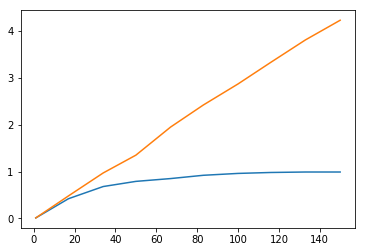

In [11]:
def calc_skills_coverage():
    xs=[]
    ys=[]
    ycnts=[]
    n_factors, min_active, max_active = 100,1,5
    n_students = 1
    tw=1
    a0=1
    a1=1
    max_n_qns = 150
    n_questions_list = numpy.linspace(1,max_n_qns,num=10).astype("int")

    _, _, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=max_n_qns)
    for n_questions in n_questions_list:
        cnt = numpy.array([False]*n_factors).astype("int")
#         plt.hist(qz_temp.flatten(), alpha=0.5)
#         plt.show()
        for q in qz_temp[0:n_questions]:
            active = (q > -10).astype("int")
#             print("a",active)
            cnt = cnt + active
            seen = numpy.clip(cnt, 0,1)
        print("c",cnt)
        print(n_questions, numpy.mean(seen), numpy.mean(cnt))
        xs.append(n_questions)
        ys.append(numpy.mean(seen))
        ycnts.append(numpy.mean(cnt))
    plt.plot(xs,ys)
    plt.plot(xs,ycnts)
    plt.show()
    
calc_skills_coverage()

In [12]:
gen_m_cache = pickle.load(open("generators.p", "rb"))

In [25]:
gen_m_cache = {}

In [86]:
tup = (100,100,100)
n_factors, min_active, max_active = tup

# sss = [10,20,30,50,70]
# nits = [1000,10000,50000]
sss = [70]
nits = [10000]


for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
#         if key in gen_m_cache:
#             del gen_m_cache[key]
        print("creating genny")
        gen_m, history, best_dims, best_mse = create_offset_generator(n_factors, min_active, max_active, sampsize=ss, n_iter=nit)
        gen_m_cache[key] = (gen_m, history, best_dims, best_mse)

        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
#         plt.title('Model loss for {}x{}'.format(ss,nit))
#         plt.ylabel('loss')
#         plt.xlabel('epoch')
#         plt.legend(['train', 'test'], loc='upper right')
#         plt.show()

creating genny
generating generator training mini-datasets...
1 0.7598055232508328
2 0.8237878708333963
3 0.383905259193379
4 0.8487116394262718
5 0.6577793245098177
6 0.2054717625594639
7 0.7487684168695968
8 0.38929705788598257
9 0.12108663313435122
10 0.256823906918127
11 0.382305515183307
12 0.10300822860047716
13 0.16575833276858787
14 0.5559456819930255
15 0.2962357038623246
16 0.7244795456615202
17 0.3268295822531117
18 0.2038667751143068
19 0.6648730184557995
20 0.7250688349916662
21 0.4510543258356441
22 0.7102840247492216
23 0.1077967749405309
24 0.810934370183816
25 0.2028155338042366
26 0.11691803419416977
27 0.3970324075248967
28 0.8610657233762623
29 0.479286157379773
30 0.8902330250616339
31 0.6088922253272359
32 0.1933002096752305
33 0.6931573701799901
34 0.1133581869581548
35 0.5311040769117629
36 0.2882552926204832
37 0.7793429528658389
38 0.4829093198181253
39 0.4570527468308636
40 0.5509442386565756
41 0.5478878207517416
42 0.561533681013987
43 0.3498707044185109
44

356 0.3892204768957357
357 0.7461438317955256
358 0.2299261781469836
359 0.239787876296303
360 0.8379084044056607
361 0.3468424926160514
362 0.4958623382777681
363 0.20063081527511814
364 0.6806597656504143
365 0.632238796060087
366 0.3472574827652273
367 0.7994172574984371
368 0.3773678602655605
369 0.7771693641279062
370 0.8646283921782504
371 0.8467251860303567
372 0.19878966685751515
373 0.64281671871724
374 0.8730136766034077
375 0.4903207598428444
376 0.2071592212196522
377 0.7699133095342627
378 0.3141541888697549
379 0.759967259772202
380 0.6424698275006319
381 0.5833376609567282
382 0.8985081559694728
383 0.7408909440241985
384 0.32479841581440116
385 0.48600355381455806
386 0.23082654437419362
387 0.7850220593531041
388 0.4150317508406664
389 0.6702074857105249
390 0.33254906569334775
391 0.7487553421507909
392 0.4939500056292167
393 0.8915063546541441
394 0.7527657476553451
395 0.7659027780346167
396 0.21755936582645288
397 0.2096339761485516
398 0.6988666457408493
399 0.145

710 0.23793720425933387
711 0.549352399857731
712 0.5921269438171869
713 0.7859525670061712
714 0.5876575234609948
715 0.7179204197159229
716 0.7705153259336854
717 0.8532432808012032
718 0.8585196319246522
719 0.8996398324376684
720 0.7467103416663113
721 0.7106986463326564
722 0.41095693664122157
723 0.6646056317382018
724 0.20582969009579957
725 0.7409669244335619
726 0.6989170266127823
727 0.35322545623788637
728 0.6047026343748227
729 0.3594287722904638
730 0.6723391393028418
731 0.8032853109490128
732 0.5674492609397068
733 0.8231000793328215
734 0.5580951441320475
735 0.33724804448430945
736 0.6778805582728894
737 0.32310338771016284
738 0.5086593457749488
739 0.22438039143430874
740 0.4842373643908336
741 0.5907188579842974
742 0.8837219804379396
743 0.7952555198902757
744 0.5082469492077065
745 0.2962757460062477
746 0.37468092352805366
747 0.12687803530171535
748 0.6007080155637673
749 0.33141291326804045
750 0.24973320060201867
751 0.8975467665092984
752 0.3662754393749079
7

1063 0.3584587285773566
1064 0.8921085604691863
1065 0.8836530041838967
1066 0.6304578980349763
1067 0.8004515577951181
1068 0.24428799142187113
1069 0.7889213284458906
1070 0.2943212559521826
1071 0.823535948892596
1072 0.622468583812135
1073 0.3992421350531157
1074 0.8912165519141646
1075 0.7515896370464977
1076 0.36755048134811724
1077 0.13815718393833007
1078 0.17019900715005326
1079 0.10005943774377517
1080 0.3297390430563724
1081 0.14977713702764642
1082 0.2968698299349208
1083 0.4808930046670387
1084 0.7816348082971829
1085 0.2331820282564006
1086 0.37266249928736905
1087 0.6690142830518857
1088 0.7672915071691839
1089 0.8425443532077623
1090 0.4307969293008196
1091 0.2723309521331749
1092 0.31184160294679447
1093 0.8260913957234624
1094 0.8684414158275294
1095 0.7605771819934563
1096 0.4193388885036813
1097 0.2988816039720581
1098 0.7153699905634563
1099 0.4556540988197766
1100 0.19428694716049827
1101 0.14875433196992335
1102 0.7911599847994395
1103 0.7768581354198965
1104 0.1

1401 0.6423110991615821
1402 0.8398701077398348
1403 0.7900465432927875
1404 0.12031289344591067
1405 0.5466634688432769
1406 0.3998310377045484
1407 0.25034467510775393
1408 0.874722452870667
1409 0.39454422444032977
1410 0.8869346827516563
1411 0.25512207262671405
1412 0.10477974341816773
1413 0.3430923466502031
1414 0.3406983182788928
1415 0.8770410404997202
1416 0.38531915261200944
1417 0.238399247169495
1418 0.5668327543088504
1419 0.11228395539827087
1420 0.12441786519438792
1421 0.18229416348446065
1422 0.4707095711815423
1423 0.21751954016002745
1424 0.668598738423978
1425 0.16523900093538874
1426 0.8687889229571628
1427 0.3999593017845514
1428 0.3841425715121605
1429 0.5258634062886491
1430 0.13522355048649046
1431 0.6722712805073667
1432 0.3441316104618811
1433 0.6680118661928363
1434 0.7120631766190444
1435 0.653505006123223
1436 0.8156907538681822
1437 0.6939674395766702
1438 0.23559715782688925
1439 0.17884935327397303
1440 0.5497319988266509
1441 0.8887231184040021
1442 0

1740 0.7176356572823229
1741 0.802920264819314
1742 0.14166086983535855
1743 0.12831323432072272
1744 0.7456433491581675
1745 0.1530857272438655
1746 0.5206347506570718
1747 0.4962540218738953
1748 0.4692899909818461
1749 0.1789581719842485
1750 0.2483745477251115
1751 0.17180113484411158
1752 0.8898048477283086
1753 0.48139435734854014
1754 0.2663198467697488
1755 0.8227236871486141
1756 0.7599184611919898
1757 0.48499309941035934
1758 0.3245118103398085
1759 0.4456984990598523
1760 0.23127944744983076
1761 0.6180363273878592
1762 0.8977023260042546
1763 0.8494583496157211
1764 0.7493594712630232
1765 0.5790582859853205
1766 0.8974345443652884
1767 0.14172840382944818
1768 0.6704101032875758
1769 0.37867109480417627
1770 0.1049745349996584
1771 0.490156623232067
1772 0.12363739920268427
1773 0.6541053660214973
1774 0.12519485763562968
1775 0.8811641369948442
1776 0.4299754252683043
1777 0.16867915530518207
1778 0.13419424195636714
1779 0.2120076326647272
1780 0.16537786173102428
1781 

2080 0.4526071290365534
2081 0.2722599664848366
2082 0.4550642778380075
2083 0.8112254273615149
2084 0.7620399763698661
2085 0.7431187280186579
2086 0.5690212523810326
2087 0.11360287830848849
2088 0.13797307298232717
2089 0.7954535727275271
2090 0.398871783117619
2091 0.6582640572566306
2092 0.5558836609115826
2093 0.8615059320212693
2094 0.8739098852947281
2095 0.7232858664781706
2096 0.5584283774170611
2097 0.10897497208987077
2098 0.326787813941994
2099 0.5884156961958291
2100 0.7331589706700771
2101 0.8568920130221137
2102 0.24726673932352622
2103 0.11139264768350461
2104 0.11669821384090664
2105 0.342451716290456
2106 0.6443064741001061
2107 0.7152713544489653
2108 0.1960684724069724
2109 0.3275169079488549
2110 0.42391683748575276
2111 0.12138585969318624
2112 0.6808684706225341
2113 0.20995460436764227
2114 0.710167177302975
2115 0.6595750018974527
2116 0.10035922894503692
2117 0.88612801815705
2118 0.6106412339064705
2119 0.6171956346889234
2120 0.3230070433439885
2121 0.46224

2420 0.7961335968567956
2421 0.5704344909893837
2422 0.3093569918423427
2423 0.3533546393180807
2424 0.32115705748120005
2425 0.7984730800785705
2426 0.10599308739209937
2427 0.149452984890183
2428 0.3399226345311837
2429 0.3781743672481381
2430 0.5411512272101561
2431 0.25377279637967953
2432 0.23010646550851246
2433 0.5449317714580135
2434 0.28784236796907764
2435 0.6191258218919066
2436 0.8818488971361313
2437 0.8228389141276995
2438 0.16156582798322888
2439 0.8582458503229072
2440 0.27481850131642543
2441 0.3047084457195868
2442 0.3464240461488407
2443 0.37103475230166877
2444 0.42540345928694345
2445 0.561580887230268
2446 0.125086302191052
2447 0.24351160784699677
2448 0.764889662804771
2449 0.6197029231345185
2450 0.3773844063381946
2451 0.8856696063210683
2452 0.5893930089437768
2453 0.5896586505552655
2454 0.8127740399722251
2455 0.2502788403294872
2456 0.5373020412118633
2457 0.6909655897233234
2458 0.5278222810840038
2459 0.5184803576886965
2460 0.10604624376673968
2461 0.24

2759 0.8700094023309066
2760 0.5502834980249599
2761 0.8153626505937951
2762 0.8726469975044668
2763 0.7680711553607212
2764 0.6926752067153985
2765 0.12308330182388674
2766 0.5915043357738377
2767 0.6319429441537908
2768 0.4197530247006376
2769 0.8098715310369479
2770 0.47014266127031284
2771 0.4953220471047011
2772 0.6153845399714976
2773 0.41279071069588325
2774 0.7206363597672373
2775 0.6580678753139084
2776 0.47277539772953614
2777 0.425068985385171
2778 0.17631638520315526
2779 0.20728246535402148
2780 0.4393822081294608
2781 0.23359210402761324
2782 0.21625336504267154
2783 0.46362687584860773
2784 0.19550944514006108
2785 0.448578776752336
2786 0.7387790899314399
2787 0.7559924012798915
2788 0.890046280384631
2789 0.725751131189551
2790 0.13686500622700806
2791 0.5623070452677529
2792 0.633726362906077
2793 0.6238606247512324
2794 0.7471584497313868
2795 0.24212331591081906
2796 0.826474182040875
2797 0.7421643579674718
2798 0.19431581748420734
2799 0.5821461909196032
2800 0.72

3100 0.6712899188219105
3101 0.4898816145353057
3102 0.5247524771598313
3103 0.7618704552400982
3104 0.638018964896963
3105 0.16509094142448325
3106 0.33260654692100594
3107 0.6450980509684201
3108 0.8352618329187111
3109 0.7166456802925517
3110 0.6855646587576114
3111 0.4317490940942581
3112 0.14865612496647942
3113 0.15785484062147787
3114 0.11550881897498376
3115 0.5398489244550921
3116 0.1346867614053282
3117 0.6396801167908193
3118 0.8385822202755762
3119 0.8536974274850425
3120 0.6442693668717875
3121 0.23019532902369513
3122 0.856996029263814
3123 0.2949887306602137
3124 0.45016563975608626
3125 0.8303992844972191
3126 0.5107262529251223
3127 0.12774999697311273
3128 0.23838626576474412
3129 0.2366030442246596
3130 0.2542213181445143
3131 0.18644263290597243
3132 0.7932298282836063
3133 0.4719135771606262
3134 0.29738213336891733
3135 0.6797863522170334
3136 0.5853375325224247
3137 0.6766211971174015
3138 0.1929056950650166
3139 0.6759344696095427
3140 0.5047064451208307
3141 0.

3440 0.7177312776752757
3441 0.29156408507200793
3442 0.17223622745278847
3443 0.5165323714080429
3444 0.7611264761016954
3445 0.18261723099844168
3446 0.7981667918440899
3447 0.5541334144752204
3448 0.6050633723035875
3449 0.3796324437461389
3450 0.17707735761175578
3451 0.28705385628014035
3452 0.2785574212674556
3453 0.3511609684051694
3454 0.8457438163266229
3455 0.2505080585951163
3456 0.11387021627120515
3457 0.7954585947808004
3458 0.32162714772370044
3459 0.21895136678181396
3460 0.1429886340227579
3461 0.8889899307789194
3462 0.1053116709785966
3463 0.6153851756946038
3464 0.3525657590317617
3465 0.2971715758814521
3466 0.8532808480341477
3467 0.36588029262878097
3468 0.13098429782051885
3469 0.48212764040390316
3470 0.6131685456154058
3471 0.3433931725597293
3472 0.27628474783847784
3473 0.8949861218849728
3474 0.8535977595067022
3475 0.6106524544746263
3476 0.4934931849915475
3477 0.21989423438215142
3478 0.23506744489668202
3479 0.15821585959532455
3480 0.22077315938363268


3778 0.8134528344506399
3779 0.5602669939288669
3780 0.2808440616441911
3781 0.7356629707444547
3782 0.6873270543361455
3783 0.417470765044949
3784 0.33164002749684823
3785 0.67055752843726
3786 0.5358866448097156
3787 0.23073091986498293
3788 0.5884735146604485
3789 0.5440530913080629
3790 0.32874089171543885
3791 0.2714119590616902
3792 0.8267454110614156
3793 0.8280992941975402
3794 0.895744453350667
3795 0.23208640866629715
3796 0.4532838732405126
3797 0.1647812502406461
3798 0.2689606750520976
3799 0.6669209469975146
3800 0.6145019228941428
3801 0.7340489048697773
3802 0.13731150118954535
3803 0.29298190721979633
3804 0.5019135839564679
3805 0.5241140090763692
3806 0.12793315159117113
3807 0.5808920246918335
3808 0.8081024554286893
3809 0.18019239673503662
3810 0.6901333843683737
3811 0.7989759042456321
3812 0.8108018128766596
3813 0.6881144709455101
3814 0.118668667661641
3815 0.26768318184184814
3816 0.39566937228033017
3817 0.492661272868881
3818 0.5733953560157504
3819 0.88850

4118 0.757555529042979
4119 0.7094847428981571
4120 0.3589693070885805
4121 0.7900048711567579
4122 0.4245311961586963
4123 0.6137478979833636
4124 0.8878668523689609
4125 0.19854983511934432
4126 0.38346625592858524
4127 0.7319535507737293
4128 0.7747502618755755
4129 0.5209521324086818
4130 0.7671341969817942
4131 0.475395703621849
4132 0.7876006466326965
4133 0.7721899133177355
4134 0.25958121168592907
4135 0.2621310054661565
4136 0.36076350369137083
4137 0.3605951480520632
4138 0.8711313221962047
4139 0.4255036609599063
4140 0.3497206918851938
4141 0.8833141804452038
4142 0.17655324695109323
4143 0.199313724490582
4144 0.7552079844404044
4145 0.4033606349079792
4146 0.3561513097684817
4147 0.7377425316910905
4148 0.6728929862235439
4149 0.5015705154039664
4150 0.6363247814294782
4151 0.24071903994031654
4152 0.14146078936441575
4153 0.21496066532485467
4154 0.4653452942378618
4155 0.21878251444836389
4156 0.7821160134117954
4157 0.25615460310424415
4158 0.4820398752955394
4159 0.85

4458 0.24350370884008693
4459 0.31598034438700195
4460 0.6754019020217771
4461 0.7952693765501403
4462 0.3386324636178738
4463 0.4487136535608039
4464 0.3991525496107168
4465 0.8058015650292129
4466 0.7226050307687952
4467 0.7788448682277838
4468 0.5735939363387396
4469 0.49981547612231664
4470 0.5775676896667274
4471 0.8018956114061552
4472 0.877509771728365
4473 0.10659049367432978
4474 0.16008698716864803
4475 0.8296132148042653
4476 0.766681388998073
4477 0.3616208125913221
4478 0.2335657165249292
4479 0.611775416331923
4480 0.16839327224547418
4481 0.3080747448916897
4482 0.7298047527548716
4483 0.3905633436407029
4484 0.7897545602030952
4485 0.5557908965126485
4486 0.32949938829172465
4487 0.7262346837349967
4488 0.48489090925540507
4489 0.17393473760164374
4490 0.6994723328822643
4491 0.8733976771796466
4492 0.5822269420574199
4493 0.8642310639782128
4494 0.6671686490252483
4495 0.5485633875754775
4496 0.423555359221845
4497 0.658837807266414
4498 0.7195314749686713
4499 0.87348

4799 0.8373908472738403
4800 0.2554450535160761
4801 0.23567334244844693
4802 0.8038326031953982
4803 0.44345708641427456
4804 0.6602072974179163
4805 0.28896019263253636
4806 0.21827572325023836
4807 0.16513464606416278
4808 0.4516229092727622
4809 0.6620887410266805
4810 0.5531563974112703
4811 0.40277854697734994
4812 0.8796708278079525
4813 0.8734510084209098
4814 0.8735779797017134
4815 0.16271774198273303
4816 0.4080809239631373
4817 0.4912986831323842
4818 0.8328732214815898
4819 0.859234251820255
4820 0.8724915081460297
4821 0.42361375708908383
4822 0.8074460533778627
4823 0.42252136316472955
4824 0.2745175876941555
4825 0.6838812965411337
4826 0.6189470165927002
4827 0.8051440391840624
4828 0.6450001975512675
4829 0.8784250695216895
4830 0.2483014183115162
4831 0.24278230522027505
4832 0.4167416378921689
4833 0.5215753426072903
4834 0.32560750229823704
4835 0.8009470900950916
4836 0.33875722213083836
4837 0.6780953593255459
4838 0.23356363830922047
4839 0.25445168628539266
484

5141 0.6036698283790187
5142 0.2708712404535638
5143 0.5016707967222429
5144 0.7565856979864038
5145 0.493521670632829
5146 0.43960577192879946
5147 0.785481132608047
5148 0.1110472800249674
5149 0.10828304668237752
5150 0.40546230899829594
5151 0.13894689731814114
5152 0.8699018806253149
5153 0.7839250027052996
5154 0.5096639577897494
5155 0.18857346631539412
5156 0.35647974000051136
5157 0.39633277030972536
5158 0.2569600451995635
5159 0.6159517572233905
5160 0.1439226109162468
5161 0.37035910895877916
5162 0.5441979019186332
5163 0.5992830289241686
5164 0.7960037606895882
5165 0.5634778862653724
5166 0.8546156769057649
5167 0.7055914571607432
5168 0.818439066157271
5169 0.34427462291751293
5170 0.17105248954680558
5171 0.14383687805229545
5172 0.33361373062915595
5173 0.1685841051323176
5174 0.30170582734193685
5175 0.2790805032915138
5176 0.8444360527073924
5177 0.38991042669124854
5178 0.8336562127377859
5179 0.7707225394614882
5180 0.5813359479824032
5181 0.3541975001277312
5182 

5481 0.6387370475549508
5482 0.6241320427873993
5483 0.1942921609663007
5484 0.16414799997477836
5485 0.34705540677141916
5486 0.20569993844965737
5487 0.4226603483799974
5488 0.20650243434399282
5489 0.791889443007625
5490 0.14448693069889781
5491 0.15423371556229998
5492 0.13794302426102098
5493 0.5915159709516982
5494 0.888739318970899
5495 0.8951245910832659
5496 0.2676638860943114
5497 0.12707023840697484
5498 0.694359624060956
5499 0.15832024203458134
5500 0.42551066693556167
5501 0.5267368676586877
5502 0.1360839688057424
5503 0.7085872698697477
5504 0.8543735781042995
5505 0.6982881603678829
5506 0.7146256737151148
5507 0.3811130085273989
5508 0.6671786629465503
5509 0.81790228232003
5510 0.4297589092949568
5511 0.260108788570485
5512 0.6508951707409918
5513 0.6377337373021864
5514 0.1402149165739774
5515 0.40138475272095925
5516 0.4658940670736245
5517 0.2963801966891988
5518 0.7634979748215316
5519 0.35131463248608535
5520 0.13115774245091893
5521 0.6848502233192325
5522 0.58

5820 0.8115922323915501
5821 0.6297866070870718
5822 0.7678611670670921
5823 0.47119645285194267
5824 0.2165105355506364
5825 0.8615423661786512
5826 0.6834931667901049
5827 0.5398900157378186
5828 0.19514561005124265
5829 0.5153038578313861
5830 0.40125025594817715
5831 0.32712512766926644
5832 0.2844703747550438
5833 0.31018829652502833
5834 0.1829783975730269
5835 0.470392212915108
5836 0.13067340165810856
5837 0.6801366534441974
5838 0.35509773613437884
5839 0.4946953768360354
5840 0.7274019163175793
5841 0.5310652032536193
5842 0.10295577002025691
5843 0.8769241645294402
5844 0.8772874294448406
5845 0.6727538539693614
5846 0.7611442132744636
5847 0.4643444671894101
5848 0.21911164373713407
5849 0.6159303451263427
5850 0.2956599344472936
5851 0.8351155799925134
5852 0.13633882881621043
5853 0.8631839796723411
5854 0.665821086575785
5855 0.3311560817184401
5856 0.156808317895045
5857 0.6786214252511279
5858 0.6615207664395756
5859 0.8008100532839106
5860 0.7585447584743832
5861 0.83

6160 0.10939962089745164
6161 0.17874797531145348
6162 0.10330739833815655
6163 0.4442027539328604
6164 0.8121035567377431
6165 0.8834195080154374
6166 0.591944246096034
6167 0.513629262305491
6168 0.8904443293732973
6169 0.11712888531629216
6170 0.6196186582746499
6171 0.28768273071329414
6172 0.23117236768196936
6173 0.1075212393152732
6174 0.48592213105852206
6175 0.3101691049562173
6176 0.5886560323603811
6177 0.821021744579085
6178 0.6945119812963771
6179 0.8185950053895765
6180 0.7249009241529759
6181 0.8507657691706803
6182 0.16550985477205724
6183 0.18218399275386185
6184 0.6232015108685623
6185 0.5580592616363792
6186 0.7184891412041005
6187 0.7775388276753462
6188 0.7063293935496495
6189 0.6982298034967034
6190 0.7315905831315823
6191 0.709657561134183
6192 0.6064377773546854
6193 0.162625964835396
6194 0.8885719298798008
6195 0.787713169434273
6196 0.7988404710260105
6197 0.8858051343734447
6198 0.3811635360544611
6199 0.5341483936342656
6200 0.10756127134659332
6201 0.46577

6500 0.8646371905733095
6501 0.5724803905321261
6502 0.4874367678468299
6503 0.8630351791605202
6504 0.8785978932535337
6505 0.8411958223868282
6506 0.6707277829181697
6507 0.8520307022739275
6508 0.2695054394236602
6509 0.769588933761243
6510 0.8807451916465991
6511 0.7727284675024952
6512 0.723518683454822
6513 0.11666668112068983
6514 0.12869588791235984
6515 0.8052613272515182
6516 0.5192391230037231
6517 0.8381536968700911
6518 0.6521773844412695
6519 0.700090381685325
6520 0.6484112116846322
6521 0.5485817428689728
6522 0.11374978234329823
6523 0.8560116024989012
6524 0.12516988202369686
6525 0.6108842725171286
6526 0.43889688351160094
6527 0.8658577457273291
6528 0.6256129590298398
6529 0.1647506782896247
6530 0.5839208941164997
6531 0.8203117208093696
6532 0.22905415889459485
6533 0.7603030435474415
6534 0.22253400611881896
6535 0.34528857269096946
6536 0.5590601559612216
6537 0.10445126931421078
6538 0.4104250419396737
6539 0.1248027381943232
6540 0.8523143827586519
6541 0.705

6844 0.20946852864696588
6845 0.8492553532627866
6846 0.18758178349294632
6847 0.6300097981759449
6848 0.8924637641291767
6849 0.5105266498815931
6850 0.29016779606755844
6851 0.8200648031399903
6852 0.2783814399891097
6853 0.16740844959115972
6854 0.5782207524064871
6855 0.7300602822741288
6856 0.5465482592745136
6857 0.4533062393827932
6858 0.4036299537701505
6859 0.20526214924780073
6860 0.630572440764965
6861 0.8811393490037176
6862 0.5316156970706445
6863 0.5799478169737013
6864 0.4474135192448586
6865 0.6268187562223849
6866 0.8439666350329863
6867 0.2693325483583991
6868 0.3817851033593775
6869 0.8087618598218392
6870 0.5356073671504898
6871 0.12445726132026576
6872 0.39835001373885576
6873 0.8608247785184261
6874 0.8605544466023928
6875 0.899908631762937
6876 0.6232149316527918
6877 0.39336812560734086
6878 0.7080264266666969
6879 0.5927403342058738
6880 0.3459719538863143
6881 0.43469344364650503
6882 0.19494246940086668
6883 0.12052383924109863
6884 0.8054362907332119
6885 0.

7182 0.10158953149992074
7183 0.12308216065159935
7184 0.2851334851847041
7185 0.16420062252554468
7186 0.3616803348099541
7187 0.4139470742163316
7188 0.16006392270278658
7189 0.7270165016990219
7190 0.8913447016033138
7191 0.7870115125366635
7192 0.17517478073838477
7193 0.29900921616822485
7194 0.3664053260622459
7195 0.3703597832200802
7196 0.5216391402108435
7197 0.1212603657097214
7198 0.769056605972127
7199 0.25973913234072166
7200 0.7661975716136852
7201 0.31079535064432945
7202 0.10463501741356565
7203 0.5325996499660827
7204 0.8135174693995547
7205 0.12247608962953048
7206 0.23195527819880404
7207 0.7602785630140622
7208 0.38311713072594805
7209 0.1951840571278624
7210 0.4435711203152283
7211 0.6943367992674826
7212 0.1951669154102774
7213 0.15526252480067046
7214 0.6415138285271801
7215 0.4715944702436406
7216 0.2252388925743167
7217 0.7886794185257688
7218 0.5770089208064442
7219 0.8371414534929682
7220 0.6203779919367336
7221 0.8283587832976185
7222 0.6600351305982963
7223

7523 0.7599121396479638
7524 0.2508590856083932
7525 0.46349798695498284
7526 0.6039352980013148
7527 0.27569557158753627
7528 0.5219501584882745
7529 0.14112042387068383
7530 0.10154333327221711
7531 0.38641470905433356
7532 0.6424473544603821
7533 0.7746075459844702
7534 0.31953857725828666
7535 0.12716414758769168
7536 0.20281569038173428
7537 0.42621938676159515
7538 0.682821774907374
7539 0.7690404697224955
7540 0.14066288977399422
7541 0.2579330365713876
7542 0.20557380707266473
7543 0.33202570102540563
7544 0.5892501624669301
7545 0.8961757624493769
7546 0.6764689577476256
7547 0.4393764073727609
7548 0.49527148599667453
7549 0.5837530592256
7550 0.36088232806265297
7551 0.18294159717642466
7552 0.3556277350919831
7553 0.22676293663569191
7554 0.8873203262158176
7555 0.6125070854604222
7556 0.8074261199773891
7557 0.18391625836147557
7558 0.8199648805708342
7559 0.5239362737980333
7560 0.21108575535310026
7561 0.29160390636778194
7562 0.8208596472858474
7563 0.6002382940739589
7

7863 0.5176237330638783
7864 0.48262522700271515
7865 0.7728284907993237
7866 0.3642513011235402
7867 0.6415580255069308
7868 0.8561078871346701
7869 0.5741072269860077
7870 0.8034201724578398
7871 0.7292774382385981
7872 0.7211191341326952
7873 0.4894615273909086
7874 0.3011324618577336
7875 0.18598487625990817
7876 0.18491945449397082
7877 0.5684813090342858
7878 0.6728925937198845
7879 0.12285442318710466
7880 0.433060677732382
7881 0.1105065666933636
7882 0.8637679012757207
7883 0.4779332825540203
7884 0.6267320726707852
7885 0.11985159317262555
7886 0.12360422299268274
7887 0.7204977064254512
7888 0.20058517645171625
7889 0.3687027209153443
7890 0.7997931815524095
7891 0.25120036765994264
7892 0.7001680702210547
7893 0.4821377574852943
7894 0.32219284710938084
7895 0.21004931496808005
7896 0.5378596679539294
7897 0.7870148573781521
7898 0.23376436186095578
7899 0.23644710981164294
7900 0.5067801062758372
7901 0.6512149587365725
7902 0.5568159553379685
7903 0.15159886713763593
7904

8205 0.4399583116435492
8206 0.5592516130315301
8207 0.5159176287718706
8208 0.8942668624080422
8209 0.48721175760756397
8210 0.10913124210883322
8211 0.6542252487611089
8212 0.3019410007259486
8213 0.1715992241353626
8214 0.8368099884335974
8215 0.6231022993024687
8216 0.808356234246097
8217 0.17174896990354832
8218 0.6252734660876789
8219 0.7719558146640438
8220 0.2786446846846779
8221 0.10708305331649699
8222 0.7223399886911286
8223 0.8681960165460867
8224 0.5068525765842693
8225 0.5305729256147736
8226 0.31505504909414306
8227 0.3253582777496645
8228 0.10281601958927461
8229 0.20676072220887332
8230 0.5130306140631381
8231 0.29191568919011934
8232 0.8326828982705704
8233 0.6966962802419334
8234 0.20163306134009357
8235 0.3129836691060306
8236 0.5296448012539063
8237 0.4160495233959202
8238 0.17477881828228392
8239 0.48433206626321557
8240 0.22392648366644505
8241 0.34423795506010174
8242 0.6942201512616681
8243 0.5502878317915683
8244 0.3428630754822784
8245 0.37478962501899016
824

8545 0.860923297950318
8546 0.7715995838388319
8547 0.13054239774012963
8548 0.25015488694976257
8549 0.5011124216411291
8550 0.2265362232223376
8551 0.8119037826406436
8552 0.1228837712054009
8553 0.5925633408230274
8554 0.8071764418324765
8555 0.18305189104411043
8556 0.19491084088410823
8557 0.5601677889332137
8558 0.7850959678038114
8559 0.24636364112930217
8560 0.38907286111066486
8561 0.2859710448926012
8562 0.16974310836941534
8563 0.6409914864453001
8564 0.8923876848465526
8565 0.5449001115842119
8566 0.8465258528124063
8567 0.552504189457144
8568 0.49588957552483587
8569 0.30796171126444566
8570 0.8611288211745659
8571 0.8439335617080573
8572 0.296469317791327
8573 0.10972342512783055
8574 0.13766748938646506
8575 0.8121507506252733
8576 0.5235536719076872
8577 0.745725484621621
8578 0.8308028750900122
8579 0.7122400864644233
8580 0.3726966069846384
8581 0.750952647620502
8582 0.7083899787680316
8583 0.7905108380676701
8584 0.3451622178097776
8585 0.3193086959372354
8586 0.888

8885 0.21777373461990002
8886 0.7697247112440259
8887 0.7013029891236001
8888 0.6895861802623118
8889 0.5767976119629012
8890 0.8661540669653192
8891 0.8991957412847337
8892 0.21664164753584084
8893 0.3224458638728647
8894 0.6182431105481795
8895 0.8665427183074222
8896 0.15433607548761394
8897 0.21312652938326213
8898 0.8289095054869833
8899 0.5675311320960287
8900 0.11172104068851595
8901 0.6464307430285873
8902 0.28008202492731876
8903 0.6451042375886051
8904 0.6069158045305559
8905 0.5325639897527141
8906 0.5500213575478371
8907 0.4837119079747673
8908 0.8726904078394164
8909 0.45483304350847237
8910 0.20260693655342107
8911 0.6067321801114701
8912 0.6106430528078444
8913 0.2255224217835439
8914 0.43424002882155016
8915 0.6206726327536106
8916 0.6726529360410363
8917 0.8641289354234527
8918 0.8692609523356791
8919 0.11356405361315143
8920 0.6413545476245274
8921 0.5199552384258856
8922 0.290396107217672
8923 0.6295390357840395
8924 0.5864607126440171
8925 0.17848371383550649
8926 0

9225 0.38657239328337234
9226 0.31698320280312203
9227 0.8901651812807219
9228 0.158951591341134
9229 0.10813947095373033
9230 0.1035344372122702
9231 0.2547005730951191
9232 0.805326928109318
9233 0.6115026418089055
9234 0.3017392371200262
9235 0.8474913300576931
9236 0.2522062539279619
9237 0.8593208539427408
9238 0.2048333982142804
9239 0.17834964067888387
9240 0.20219538822922586
9241 0.8682910560196176
9242 0.2797185293668028
9243 0.16369737970347245
9244 0.7778884373325843
9245 0.8840749495320104
9246 0.23598027186575846
9247 0.7132106952623668
9248 0.6458195875659807
9249 0.7970728378065218
9250 0.8520495139916678
9251 0.20378212320200048
9252 0.7880518278564576
9253 0.7555701594765954
9254 0.5072422234376573
9255 0.32940832193021047
9256 0.7571731277264553
9257 0.4599098573241458
9258 0.7252529515174541
9259 0.683075107126854
9260 0.5138248236106682
9261 0.17979385308465026
9262 0.5308455961158886
9263 0.30806457875448856
9264 0.8431024864689559
9265 0.7943323088111252
9266 0.8

9565 0.2470968195440385
9566 0.8687144120541634
9567 0.27438777952292437
9568 0.1724058250870444
9569 0.614781016641911
9570 0.8970636848360567
9571 0.8830225442218131
9572 0.8188894051783961
9573 0.7899046802612116
9574 0.28331046825173883
9575 0.2026229478392748
9576 0.23612200118594784
9577 0.5113748996453753
9578 0.27355700285627205
9579 0.6347981408146641
9580 0.5954392411702615
9581 0.5368180307368108
9582 0.24448682338259042
9583 0.5612649277023031
9584 0.22830711829792236
9585 0.2750704643680652
9586 0.1431796822504837
9587 0.4693786204418172
9588 0.7464227865097134
9589 0.6124530843746374
9590 0.14673040249630845
9591 0.878557255617949
9592 0.893194129441352
9593 0.27769515968775976
9594 0.8884710664262343
9595 0.1615545955478305
9596 0.46030030887697043
9597 0.6231237260161232
9598 0.3863364732088252
9599 0.8665501896326665
9600 0.6088154713745243
9601 0.7960601906596755
9602 0.8705840815084134
9603 0.12959403225717847
9604 0.13239703273426315
9605 0.8521713891558399
9606 0.8

9906 0.6996170098843646
9907 0.22731720636756408
9908 0.6648037625494873
9909 0.13798939164693633
9910 0.3591108603730636
9911 0.24010072730474163
9912 0.8954915336573124
9913 0.10571340065232071
9914 0.6612844752840927
9915 0.8901626068684799
9916 0.5775025996133345
9917 0.8191207781176624
9918 0.43478119265982107
9919 0.2637588621325019
9920 0.3641664270049733
9921 0.1951438590532481
9922 0.8141396113571537
9923 0.5927315276486947
9924 0.42008829193622055
9925 0.15862160429190952
9926 0.8777922195001109
9927 0.59685639884104
9928 0.19891846437467978
9929 0.14820858850373725
9930 0.19480459445113169
9931 0.49484470082110493
9932 0.6599862843455442
9933 0.5661010120637987
9934 0.7389034875696477
9935 0.1489709442638106
9936 0.5629978222619598
9937 0.3124685914299331
9938 0.8639821013401304
9939 0.6407082303818227
9940 0.26469289304771404
9941 0.7991452682273106
9942 0.5219168901635551
9943 0.5230282343137277
9944 0.4007591510205861
9945 0.1537970433762305
9946 0.6987609466407566
9947 0

Epoch 49/10000
900/900 [==============================] - 0s 4us/step - loss: 1.2763 - val_loss: 1.5702
Epoch 50/10000
900/900 [==============================] - 0s 4us/step - loss: 1.2648 - val_loss: 1.5549
Epoch 51/10000
900/900 [==============================] - 0s 4us/step - loss: 1.2540 - val_loss: 1.5400
Epoch 52/10000
900/900 [==============================] - 0s 3us/step - loss: 1.2434 - val_loss: 1.5257
Epoch 53/10000
900/900 [==============================] - 0s 5us/step - loss: 1.2331 - val_loss: 1.5120
Epoch 54/10000
900/900 [==============================] - 0s 4us/step - loss: 1.2231 - val_loss: 1.4983
Epoch 55/10000
900/900 [==============================] - 0s 4us/step - loss: 1.2129 - val_loss: 1.4845
Epoch 56/10000
900/900 [==============================] - 0s 5us/step - loss: 1.2023 - val_loss: 1.4706
Epoch 57/10000
900/900 [==============================] - 0s 3us/step - loss: 1.1913 - val_loss: 1.4564
Epoch 58/10000
900/900 [==============================] - 0s 3us

Epoch 128/10000
900/900 [==============================] - 0s 5us/step - loss: 0.7216 - val_loss: 0.8264
Epoch 129/10000
900/900 [==============================] - 0s 3us/step - loss: 0.7186 - val_loss: 0.8224
Epoch 130/10000
900/900 [==============================] - 0s 5us/step - loss: 0.7157 - val_loss: 0.8185
Epoch 131/10000
900/900 [==============================] - 0s 4us/step - loss: 0.7128 - val_loss: 0.8146
Epoch 132/10000
900/900 [==============================] - 0s 4us/step - loss: 0.7099 - val_loss: 0.8107
Epoch 133/10000
900/900 [==============================] - 0s 5us/step - loss: 0.7070 - val_loss: 0.8069
Epoch 134/10000
900/900 [==============================] - 0s 5us/step - loss: 0.7041 - val_loss: 0.8033
Epoch 135/10000
900/900 [==============================] - 0s 5us/step - loss: 0.7012 - val_loss: 0.7997
Epoch 136/10000
900/900 [==============================] - 0s 4us/step - loss: 0.6983 - val_loss: 0.7963
Epoch 137/10000
900/900 [==============================

900/900 [==============================] - 0s 4us/step - loss: 0.4733 - val_loss: 0.5416
Epoch 207/10000
900/900 [==============================] - 0s 3us/step - loss: 0.4691 - val_loss: 0.5360
Epoch 208/10000
900/900 [==============================] - 0s 3us/step - loss: 0.4649 - val_loss: 0.5304
Epoch 209/10000
900/900 [==============================] - 0s 4us/step - loss: 0.4606 - val_loss: 0.5247
Epoch 210/10000
900/900 [==============================] - 0s 6us/step - loss: 0.4562 - val_loss: 0.5189
Epoch 211/10000
900/900 [==============================] - 0s 5us/step - loss: 0.4518 - val_loss: 0.5131
Epoch 212/10000
900/900 [==============================] - 0s 5us/step - loss: 0.4473 - val_loss: 0.5073
Epoch 213/10000
900/900 [==============================] - 0s 4us/step - loss: 0.4427 - val_loss: 0.5014
Epoch 214/10000
900/900 [==============================] - 0s 4us/step - loss: 0.4381 - val_loss: 0.4952
Epoch 215/10000
900/900 [==============================] - 0s 5us/step 

Epoch 285/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1569 - val_loss: 0.1724
Epoch 286/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1544 - val_loss: 0.1695
Epoch 287/10000
900/900 [==============================] - 0s 5us/step - loss: 0.1519 - val_loss: 0.1667
Epoch 288/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1494 - val_loss: 0.1638
Epoch 289/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1470 - val_loss: 0.1610
Epoch 290/10000
900/900 [==============================] - 0s 3us/step - loss: 0.1446 - val_loss: 0.1582
Epoch 291/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1423 - val_loss: 0.1555
Epoch 292/10000
900/900 [==============================] - 0s 4us/step - loss: 0.1400 - val_loss: 0.1528
Epoch 293/10000
900/900 [==============================] - 0s 3us/step - loss: 0.1377 - val_loss: 0.1502
Epoch 294/10000
900/900 [==============================

900/900 [==============================] - 0s 4us/step - loss: 0.0423 - val_loss: 0.0433
Epoch 364/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0418 - val_loss: 0.0427
Epoch 365/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0413 - val_loss: 0.0421
Epoch 366/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0408 - val_loss: 0.0414
Epoch 367/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0403 - val_loss: 0.0408
Epoch 368/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0398 - val_loss: 0.0402
Epoch 369/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0393 - val_loss: 0.0397
Epoch 370/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0388 - val_loss: 0.0391
Epoch 371/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0384 - val_loss: 0.0386
Epoch 372/10000
900/900 [==============================] - 0s 5us/step 

Epoch 442/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0225 - val_loss: 0.0237
Epoch 443/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0224 - val_loss: 0.0237
Epoch 444/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0223 - val_loss: 0.0236
Epoch 445/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0222 - val_loss: 0.0236
Epoch 446/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0220 - val_loss: 0.0235
Epoch 447/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0219 - val_loss: 0.0235
Epoch 448/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0218 - val_loss: 0.0235
Epoch 449/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0217 - val_loss: 0.0234
Epoch 450/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0216 - val_loss: 0.0234
Epoch 451/10000
900/900 [==============================

900/900 [==============================] - 0s 4us/step - loss: 0.0165 - val_loss: 0.0183
Epoch 521/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0165 - val_loss: 0.0182
Epoch 522/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0164 - val_loss: 0.0181
Epoch 523/10000
900/900 [==============================] - 0s 6us/step - loss: 0.0164 - val_loss: 0.0180
Epoch 524/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0163 - val_loss: 0.0180
Epoch 525/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0163 - val_loss: 0.0179
Epoch 526/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0162 - val_loss: 0.0179
Epoch 527/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0162 - val_loss: 0.0178
Epoch 528/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0161 - val_loss: 0.0178
Epoch 529/10000
900/900 [==============================] - 0s 3us/step 

Epoch 599/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0133 - val_loss: 0.0146
Epoch 600/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0133 - val_loss: 0.0146
Epoch 601/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0132 - val_loss: 0.0146
Epoch 602/10000
900/900 [==============================] - 0s 6us/step - loss: 0.0132 - val_loss: 0.0145
Epoch 603/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0132 - val_loss: 0.0145
Epoch 604/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0132 - val_loss: 0.0145
Epoch 605/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0131 - val_loss: 0.0145
Epoch 606/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0131 - val_loss: 0.0144
Epoch 607/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0131 - val_loss: 0.0144
Epoch 608/10000
900/900 [==============================

900/900 [==============================] - 0s 5us/step - loss: 0.0118 - val_loss: 0.0128
Epoch 678/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0118 - val_loss: 0.0128
Epoch 679/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0118 - val_loss: 0.0128
Epoch 680/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0118 - val_loss: 0.0128
Epoch 681/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0118 - val_loss: 0.0128
Epoch 682/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0118 - val_loss: 0.0127
Epoch 683/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0117 - val_loss: 0.0127
Epoch 684/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0117 - val_loss: 0.0127
Epoch 685/10000
900/900 [==============================] - 0s 6us/step - loss: 0.0117 - val_loss: 0.0127
Epoch 686/10000
900/900 [==============================] - 0s 3us/step 

Epoch 756/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0111 - val_loss: 0.0119
Epoch 757/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0110 - val_loss: 0.0119
Epoch 758/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0110 - val_loss: 0.0118
Epoch 759/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0110 - val_loss: 0.0118
Epoch 760/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0110 - val_loss: 0.0118
Epoch 761/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0110 - val_loss: 0.0118
Epoch 762/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0110 - val_loss: 0.0118
Epoch 763/10000
900/900 [==============================] - 0s 6us/step - loss: 0.0110 - val_loss: 0.0118
Epoch 764/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0110 - val_loss: 0.0118
Epoch 765/10000
900/900 [==============================

900/900 [==============================] - 0s 4us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 835/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 836/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 837/10000
900/900 [==============================] - 0s 3us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 838/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 839/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 840/10000
900/900 [==============================] - 0s 5us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 841/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 842/10000
900/900 [==============================] - 0s 4us/step - loss: 0.0105 - val_loss: 0.0111
Epoch 843/10000
900/900 [==============================] - 0s 4us/step 

In [87]:
sss   = [10,20,30,50,70]
nits = [1000, 10000, 50000]
tup = (100,1,5)
for ss in sss:
    for nit in nits:
        key = ((tup,(nit,ss)))
        
        (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
        # summarize history for loss
#         plt.plot(history.history['loss'])
#         plt.plot(history.history['val_loss'])
        print(key, best_dims, best_mse)
# plt.title('Model loss for {}x{}'.format(ss,nit))
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train {} {}'.format(ss,nit), 'test {} {}'.format(ss,nit)], loc='upper right')
# plt.show()

((100, 1, 5), (1000, 10)) (8, 1) 0.3271068409085274
((100, 1, 5), (10000, 10)) (32, 3) 0.26942141892910004
((100, 1, 5), (50000, 10)) (32, 2) 0.27496208245754244
((100, 1, 5), (1000, 20)) (32, 1) 0.15794473707675935
((100, 1, 5), (10000, 20)) (32, 2) 0.12947245151996611
((100, 1, 5), (50000, 20)) (32, 2) 0.13169951676368713
((100, 1, 5), (1000, 30)) (16, 1) 0.1136503940820694
((100, 1, 5), (10000, 30)) (32, 3) 0.08696433037519455
((100, 1, 5), (50000, 30)) (16, 2) 0.08837443972587586
((100, 1, 5), (1000, 50)) (8, 3) 0.061261627316474915
((100, 1, 5), (10000, 50)) (16, 2) 0.051164472541213035
((100, 1, 5), (50000, 50)) (16, 1) 0.05543607542812824
((100, 1, 5), (1000, 70)) (16, 2) 0.05502187219262123
((100, 1, 5), (10000, 70)) (32, 3) 0.04145161183476448
((100, 1, 5), (50000, 70)) (16, 2) 0.03886372591853142


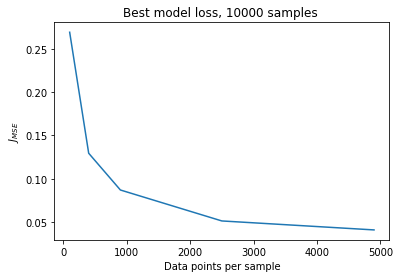

In [15]:
xs = [10,20,30,50,70]
ys = [
    0.26942141892910004,
    0.12947245151996611,
    0.08696433037519455,
    0.051164472541213035,
    0.04078790558874607
] 
x2s = [x**2 for x in xs]
plt.figure(figsize=(6,4))
plt.plot(x2s, ys)
plt.title("Best model loss, 10000 samples ")
plt.xlabel("Data points per sample")
plt.ylabel("$J_{MSE}$")
plt.show()

In [88]:
pickle.dump(gen_m_cache, open("generators.p", "wb"))

In [30]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
key = (tup, (10000,70))

if key in gen_m_cache:
#     gen_m = gen_m_cache[tup]
    (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
else:
    print(key)
    print(gen_m_cache.keys())
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.5
explore_mode = False

distro_params = []
pfz_list = []

pfzz = None #numpy.array([])
lookup = {}

i=0
explore_mode=True
toomuch, toolittle, goldi = 0,0,0
for (n_factors, min_active, max_active, _) in factors_list:

    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    found = False
    tensorflow.random.set_seed(666)
    seed(666)
    mode = "n"
    
    print(gen_m_cache.keys())
    
    for ss in sss:
        for nit in nits:
            tup = n_factors, min_active, max_active
            key = ((tup,(nit,ss)))
#             gen_m = gen_m_cache[key]
            (gen_m, history, best_dims, best_mse) = gen_m_cache[key]
            while i < 1:
                tw = random.uniform(0.5, 3.5)
                a1 = random.uniform(1, 3.5)
        #         a1 = random.uniform(1, 5)

                if mode=="n":
                    a0n = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
                else:
                    a0r = random.uniform(-1,8.7)

                print("gening data")
                _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

                print("run created")
                students2 = students_temp

            #     if questions is None:
                questions = qz_temp

        #                         qn_av = numpy.mean(questions, axis=0)
        #                         qn_std = numpy.std(questions, axis=0)

                if explore_mode:
                    plot_items([], questions, None)

                    bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                    plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                    plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                    plt.show()

                obs=numpy.zeros((len(students2), len(questions)))
                pfz = probs.flatten()
                if pfzz is None:
                    pfzz = numpy.array(pfz)
                else:
                    numpy.concatenate((pfzz, pfz))

                if explore_mode:
                #     plt.hist(probs.flatten(), alpha=0.5)
                    plt.title("Histogram of $p_{pass}$")
                    plt.xlabel("$p_{pass}")
                    plt.ylabel("Frequency")
                    plt.legend()
                    plt.show()
                    plt.hist(pfz.flatten(), alpha=0.5)
                    plt.title("pfz")
                    plt.show()          

                hard = (probs >= 0.5)
                agt = 0 #numpy.zeros_like(probs)
                n_agt_runs = 10
                for _ in range(n_agt_runs):
                    this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                    this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                    agt += this_agt / n_agt_runs
                print("*** AGT:", agt)                    

                print(tw, a1, a0)
                mn = numpy.mean(probs.flatten())
                if mn > 0.9:
                    toomuch+=1
                if mn < 0.1:
                    toolittle+=1
                if (mn < 0.6) and (mn > 0.4):
                    goldi +=1

        #         distro_params.append((vmn,agt))
                pfz_list.append(pfz)
                i+=1

        if explore_mode:
        #     plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()
            plt.hist(pfzz.flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()
        print(numpy.mean(pfzz), numpy.std(pfzz))
        print(toolittle, goldi, toomuch)

[autoreload of six failed: Traceback (most recent call last):
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 385, in superreload
    update_generic(old_obj, new_obj)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 324, in update_generic
    update(a, b)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 276, in update_class
    old_obj = getattr(old, key)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/six.py", line 93, in __get__
    setattr(obj, self.name, result)  # Invokes __set__.
AttributeError: 'NoneType' object has no attribute 'cStringIO'
]
[autoreload of numpy failed: Traceback (most recent call last):
  File "/home/rjm49/.venvs/isaac/lib/python3.6/sit

[autoreload of scipy.sparse.lil failed: Traceback (most recent call last):
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/usr/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/scipy/sparse/lil.py", line 23, in <module>
    class lil_matrix(spmatrix, IndexMixin):
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packag

[autoreload of scipy.stats._continuous_distns failed: Traceback (most recent call last):
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 385, in superreload
    update_generic(old_obj, new_obj)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 324, in update_generic
    update(a, b)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 289, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 324, in update_generic
    update(a, b)
  File "/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 267, in update_function
    setattr(ol

AttributeError: module 'tensorflow._api.v1.random' has no attribute 'set_seed'

In [103]:
from numpy.random import seed
from sklearn.model_selection import train_test_split

tup = (100,1,5)
key = (tup,(10000,70))
if tup in gen_m_cache:
    gen_m = gen_m_cache[tup]
else:
    raise Exception("Trying to use generator that does not exist")

factors_master = [tup]
w_list = [200]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

bal=0.500
explore_mode = False

distro_params = []


balance_lookup = {}


# for (n_factors, min_active, max_active, _) in factors_list:
bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    i=0
    model_list=[]
    rasch=True

    questions=None

    qws_list = []
    sws_list = []
    tr_list = []
    params_list = []
    # questions=None
    real_stu_list=[]
    real_que_list=[]
    perseverance_list=[]
    test_datasets=[]

    pred_list = []

    tensorflow.random.set_seed(666)
    seed(666)
    found = False
    
    probs_list = []
    pfz_list = []
    while i < 100:
        print("BAL target:", bal)
        tw = random.uniform(0.5, 3.5)
#                         a1 = random.uniform(1, 3.5)
        a1 = random.uniform(1, 3.5)
        a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))
#         a0 = random.uniform(-1,1.6)
#         a0 = random.uniform(-1,3.5)
 
        print("gening data")
        _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=100, n_questions=100)

        print("run created")
        students2 = students_temp

    #     if questions is None:
        questions = qz_temp

#                         qn_av = numpy.mean(questions, axis=0)
#                         qn_std = numpy.std(questions, axis=0)

        if explore_mode:
            plot_items([], questions, None)

            bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

            plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
            plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
            plt.show()

        obs=numpy.zeros((len(students2), len(questions)))

        all_pairs = []
        tr_pairs = []
        v_pairs = []
        tt_pairs = []
        perseverance = []
        slist = list(range(len(students2)))
        random.seed(666)
        shuffle(slist)
        for vi in slist:
#                             c=0
            p_cont = None #(n_students * n_questions)//5
            v_size = p_cont
            qlist= list(range(len(questions)))
            shuffle(qlist)
            first = True
            for mi in qlist:
                if first:
                    tt_pairs.append((vi,mi))
                    first = False
                else:
                    tr_pairs.append((vi,mi))

        print("splitting")
        tr_pairs, _ = train_test_split(tr_pairs, test_size=0.5, shuffle=False)
        tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1, shuffle=False)
        print("splut")

#                         print("scanning")
#                         for pa in tr_pairs:
# #                             print(pa)
#                             if pa in tt_pairs:
#                                 print("TR IN TT")
#                                 raise Exception
#                             if pa in v_pairs:
#                                 print("TR IN V")
#                                 raise Exception
#                         print("scun")

        pfz, sz, qz = stitch_n_split(tr_pairs, probs)
        vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)

        print("lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

#                         print(probs)

        hard = (probs >= 0.5)
        agt = 0 #numpy.zeros_like(probs)
        n_agt_runs = 10
        for _ in range(n_agt_runs):
            this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
            this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
            agt += this_agt / n_agt_runs
        print("*** AGT:", agt)                            

        if explore_mode:
            plt.hist(probs.flatten(), alpha=0.5)
            plt.title("Histogram of $p_{pass}$")
            plt.xlabel("$p_{pass}")
            plt.ylabel("Frequency")
            plt.legend()
            plt.show()

            plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
            plt.title("pfz")
            plt.show()


        print(tw, a1, a0)
        mn = numpy.mean(pfz)
        vmn = numpy.mean(vpfz)
        print(mn, vmn)

        distro_params.append((vmn,agt))
        pfz_list.append(pfz)
        probs_list.append(probs.flatten())
        
        i+=1
    balance_lookup[bal] = (probs_list, pfz_list)



BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92446
2.32734785472902 1.4089365651482209 [[-2.3032851]]
0.09517396184062851 0.09494949494949495
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92295
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12727272727272726 0.1292929292929293
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92401
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.13198653198653199 0.13333333333333333
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9233600000000001
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.11986531986531987 0.12121212121212122
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9286600000000002
0.6321288704918293 2.446

*** AGT: 0.92301
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12390572390572391 0.14747474747474748
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92621
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.1191919191919192 0.19393939393939394
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92405
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12121212121212122 0.15151515151515152
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9274399999999999
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12300785634118967 0.15757575757575756
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92438
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.13265993265993267 0.15555555555555556
BAL target: 0.1
gening data
run created


*** AGT: 0.9252800000000001
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.11829405162738496 0.14545454545454545
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9223599999999998
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12368125701459035 0.13333333333333333
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92497
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12615039281705948 0.12323232323232323
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92281
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.12951739618406286 0.1292929292929293
BAL target: 0.1
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.92518
0.6321288704918293 2.4468548839626463 [[-2.3118198]]
0.11380471380471381 0.14747474747474748
BAL target: 0.1
gening data
r

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89192
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.1961840628507295 0.1919191919191919
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8906700000000001
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19304152637485972 0.18181818181818182
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8902700000000001
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19349046015712681 0.1898989898989899
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.88815
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19797979797979798 0.21212121212121213
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89178
0.6321288704918293 2.4468548839626463 [[-1.4646655]]

splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89099
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19977553310886645 0.16363636363636364
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89161
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19124579124579125 0.16565656565656567
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8910600000000001
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.18945005611672278 0.16767676767676767
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.88895
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.19797979797979798 0.19393939393939394
BAL target: 0.2
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.89235
0.6321288704918293 2.4468548839626463 [[-1.4646655]]
0.1941638608305275 

*** AGT: 0.8520199999999999
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.28170594837261503 0.3212121212121212
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8507099999999999
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.28327721661054994 0.3090909090909091
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8506500000000001
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.29068462401795736 0.29494949494949496
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85646
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2915824915824916 0.28484848484848485
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8519300000000001
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2915824915824916 0.28484848484848485
BAL target

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8508800000000001
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2787878787878788 0.2767676767676768
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85577
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2835016835016835 0.2686868686868687
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84784
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2843995510662177 0.2787878787878788
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85013
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.27901234567901234 0.31313131313131315
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8531300000000002
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85542
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2841750841750842 0.30505050505050507
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8509099999999998
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2801346801346801 0.30707070707070705
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.85699
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2783389450056117 0.2787878787878788
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84773
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.29876543209876544 0.2868686868686869
BAL target: 0.3
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.84755
0.6321288704918293 2.4468548839626463 [[-0.6171858]]
0.2848484848

*** AGT: 0.82108
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.38496071829405165 0.3838383838383838
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.81945
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.38473625140291806 0.35353535353535354
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82437
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.3627384960718294 0.35555555555555557
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8224199999999999
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.37957351290684627 0.35353535353535354
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82116
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.3921436588103255 0.36767676767676766
BAL target: 0.4
gening data
run created
sp

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8245500000000001
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.38002244668911334 0.37777777777777777
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82169
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.37732884399551064 0.3878787878787879
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82254
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.3658810325476992 0.3878787878787879
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8249400000000001
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0.3824915824915825 0.3717171717171717
BAL target: 0.4
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82428
0.6321288704918293 2.4468548839626463 [[0.07707413]]
0

*** AGT: 0.7965200000000001
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.509090909090909 0.4707070707070707
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79634
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5003367003367003 0.49696969696969695
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79848
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.500561167227834 0.5313131313131313
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79713
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5120089786756453 0.5292929292929293
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79421
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.4965207631874299 0.47474747474747475
BAL target: 0.5
gening data
run created
splitting

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79872
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.49270482603815935 0.5131313131313131
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80358
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5028058361391695 0.49292929292929294
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8015099999999998
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.49809203142536473 0.5111111111111111
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80283
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5012345679012346 0.49292929292929294
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8012099999999999
0.6321288704918293 2.4468548839626463 [[0.87149364]]


gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8023899999999999
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.4922558922558923 0.4404040404040404
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.7987299999999999
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.520314253647587 0.48282828282828283
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79571
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5077441077441077 0.4909090909090909
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79556
0.6321288704918293 2.4468548839626463 [[0.87149364]]
0.5034792368125701 0.503030303030303
BAL target: 0.5
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.7965599999999999
0.6321288704918293 2.44685488396264

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80101
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6377104377104377 0.6282828282828283
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80183
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6444444444444445 0.6121212121212121
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80491
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6296296296296297 0.602020202020202
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80488
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6267115600448934 0.6303030303030303
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8025100000000001
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6334455667789001 0.

*** AGT: 0.8
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6294051627384961 0.6484848484848484
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.79922
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6307519640852974 0.6202020202020202
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8043299999999999
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6332210998877665 0.6080808080808081
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80486
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6273849607182941 0.6161616161616161
BAL target: 0.6
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.80067
0.6321288704918293 2.4468548839626463 [[1.7375281]]
0.6439955106621773 0.6343434343434343
BAL target: 0.6
gening data
run created
splitting
splut
le

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8334599999999999
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7481481481481481 0.7555555555555555
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83701
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.762962962962963 0.7616161616161616
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.82811
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7481481481481481 0.7252525252525253
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83312
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7535353535353535 0.7555555555555555
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83309
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7548821548821549 0.

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8351900000000001
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7652076318742985 0.795959595959596
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8339300000000002
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7384960718294051 0.7373737373737373
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.834
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.743658810325477 0.7616161616161616
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8358200000000001
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7530864197530864 0.7676767676767676
BAL target: 0.7
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8321800000000001
0.6321288704918293 2.4468548839626463 [[2.6

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.83456
0.6321288704918293 2.4468548839626463 [[2.6035628]]
0.7530864197530864 0.7191919191919192
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.86807
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8161616161616162 0.8343434343434344
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87289
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8325476992143659 0.8181818181818182
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8731399999999999
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8235690235690236 0.8505050505050505
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8719899999999999
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.82940516273

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8702799999999998
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8395061728395061 0.8404040404040404
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87322
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8377104377104377 0.8404040404040404
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87551
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8359147025813692 0.8525252525252526
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87354
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8278338945005612 0.8404040404040404
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8733100000000001
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.813468013468

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87217
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8395061728395061 0.8525252525252526
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8696600000000001
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.819304152637486 0.8121212121212121
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87232
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8246913580246914 0.7717171717171717
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.8699399999999999
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8190796857463524 0.8424242424242424
BAL target: 0.8
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.87247
0.6321288704918293 2.4468548839626463 [[3.288488]]
0.8448933782267

*** AGT: 0.90687
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8909090909090909 0.9111111111111111
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9056200000000001
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8817059483726151 0.9090909090909091
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9054600000000002
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8891133557800225 0.9030303030303031
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9084199999999999
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8749719416386083 0.9090909090909091
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.90513
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8868686868686869 0.8464646464646465
BAL target: 0.9
gening data
run 

run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9045899999999999
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8953984287317621 0.901010101010101
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9035300000000002
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8886644219977553 0.8767676767676768
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9065800000000002
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8711560044893378 0.8525252525252526
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.9014800000000001
0.6321288704918293 2.4468548839626463 [[3.9247057]]
0.8938271604938272 0.8606060606060606
BAL target: 0.9
gening data
run created
splitting
splut
lens of pfz and vpfz, tt_pairs 4455 495 100
*** AGT: 0.906
0.6321288704918293 2.4468548839626463 [[3.

In [114]:
# plt.hist(numpy.array(probs_list).flatten())
# plt.title("Counts of pass probabilties (Raw params, 100 trials)")
# plt.xlabel("$p_{pass}$")
# plt.ylabel("Count")

bal_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for bal in bal_list:
    (probs_list, pfz_list) = balance_lookup[bal]
    mnz = [numpy.mean(pfz) for pfz in pfz_list]
    print(bal, numpy.mean(mnz))
#     print(mnz)
    
    #print(numpy.mean(pfz_list))
    print (numpy.sqrt(numpy.mean(numpy.power(numpy.subtract(mnz,bal), 2))))


0.1 0.12537373737373733
0.025918850852463184
0.2 0.1930460157126824
0.009185990422118059
0.3 0.28467789001122334
0.01698054570410695
0.4 0.37958922558922564
0.02211424981871497
0.5 0.500909090909091
0.009078596642037699
0.6 0.634327721661055
0.03538789415854601
0.7 0.753463524130191
0.05404321388259128
0.8 0.828830527497194
0.02978473499873512
0.9 0.8833759820426487
0.017699054235002884


(0.5070707070707071, 0.49696969696969695, 0.5313131313131313, 0.4888888888888889, 0.4484848484848485, 0.5696969696969697, 0.494949494949495, 0.5050505050505051, 0.5515151515151515, 0.501010101010101, 0.49696969696969695, 0.47878787878787876, 0.5111111111111111, 0.5414141414141415, 0.5373737373737374, 0.48484848484848486, 0.49292929292929294, 0.5373737373737374, 0.501010101010101, 0.5171717171717172, 0.5393939393939394, 0.47878787878787876, 0.5595959595959596, 0.45656565656565656, 0.4888888888888889, 0.503030303030303, 0.5292929292929293, 0.4888888888888889, 0.5494949494949495, 0.5292929292929293, 0.5050505050505051, 0.4686868686868687, 0.4767676767676768, 0.4727272727272727, 0.503030303030303, 0.49696969696969695, 0.501010101010101, 0.5070707070707071, 0.49696969696969695, 0.4888888888888889, 0.5212121212121212, 0.5515151515151515, 0.5595959595959596, 0.5313131313131313, 0.5191919191919192, 0.4909090909090909, 0.498989898989899, 0.4484848484848485, 0.5050505050505051, 0.488888888888888

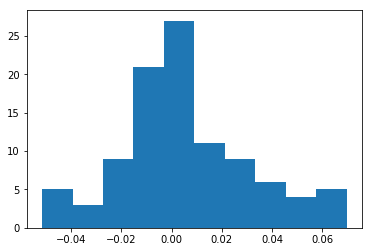

0.025861931601735392


In [89]:
mnz2, agtz2 = zip(*distro_params)
print(mnz2)
mnz2 = numpy.array(mnz2).flatten()
print (numpy.mean(numpy.power(mnz2 - 0.5, 2)))
plt.hist((mnz2 - 0.5))
plt.show()
print (numpy.std((mnz2 - 0.5)))


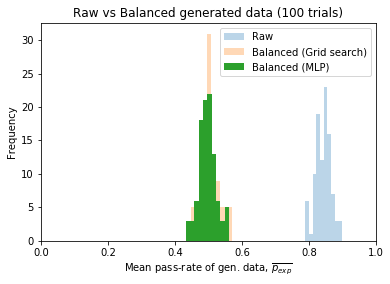

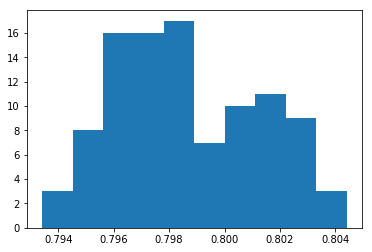

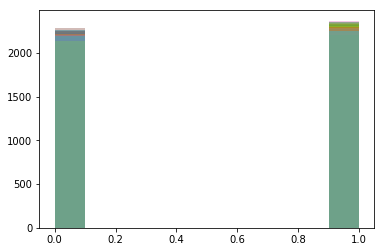

Mean of means: 0.5095465768799102
Std of means: 0.008701296538701837


In [69]:
mnz, agtz = zip(*distro_params)
plt.xlim(0,1)
plt.hist(ub_mnz, label="Raw", alpha=0.3)
plt.hist(hd_mnz, label="Balanced (Grid search)", alpha=0.3)
plt.hist(mnz, label="Balanced (MLP)", alpha=1)
plt.title("Raw vs Balanced generated data (100 trials)")
plt.ylabel("Frequency")
plt.xlabel("Mean pass-rate of generated data, $\overline{p_{exp}}$")
plt.legend()
plt.show()

plt.hist(agtz)
plt.show()

summary_mnz = []
for pfz in pfz_list:
    mn = numpy.mean(pfz)
    summary_mnz.append(mn)
    plt.hist(pfz, alpha=.4)
plt.show()

print("Mean of means:", numpy.mean(summary_mnz))
print("Std of means:", numpy.std(summary_mnz))

In [14]:
data_cache = {}

using datacache
data shape has changed, need to make new data
gening data
run created
pred list shape (0,)
real items shape (1000, 100)


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/ipykernel_launcher.py:126: RuntimeWarning: invalid value encountered in true_divide


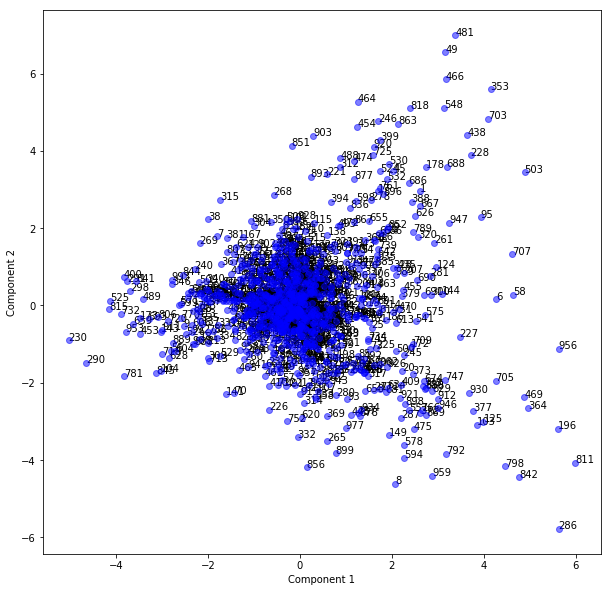

len Cs 0
Mean rand score = nan nan
~ ~ ~ ~~ ATTEMPT 0 [[2.474]]


/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


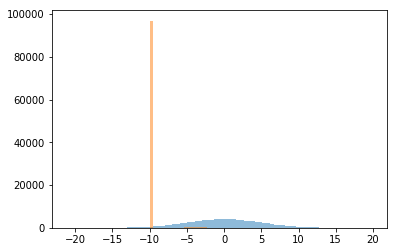

splitting
splut
Sparsity 1.0 lens of pfz and vpfz, tt_pairs 899100 99900 1000
[[0.047 0.005 0.99  ... 0.466 0.218 0.939]
 [0.667 0.001 0.384 ... 0.013 0.503 0.148]
 [0.004 0.819 1.    ... 0.999 0.98  0.961]
 ...
 [0.37  0.688 0.999 ... 0.998 0.005 0.893]
 [0.044 0.084 0.355 ... 0.244 0.001 1.   ]
 [0.628 0.359 0.996 ... 0.997 0.803 0.015]]
*** AGT: 0.8816713


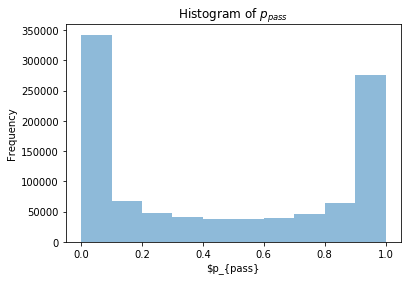

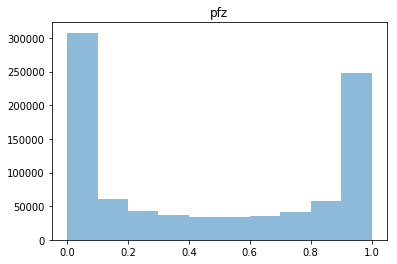

2.9738525556285875 4.906494386187433 [[2.474]]
0.46556999938354016 0.4648244806443216
xhxwx ELIGIBLE SPREAD for 0.46556999938354016 0.5 0.55 0.45
FOUND ELIGIBLE SPREAD for 0.46556999938354016 0.5 0.55 0.45
mean pers is nan
binary obs? False
callio:
899100 899100 899100
99900 99900 99900 128
nn_mode DEEP
kk (1000, 128)
selector shape (None, 1)
flat selector shape (None,)
call kk (1000, 128)
'rows' shape, (None, 128)
kk (1000, 128)
selector shape (None, 1)
flat selector shape (None,)
call kk (1000, 128)
'rows' shape, (None, 128)
Mode is DEEP
loss mode is XENT
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
psi_select (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
q_select (InputLayer)  

/home/rjm49/.venvs/isaac/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 899100 samples, validate on 99900 samples
Epoch 1/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6922 - accuracy: 7.5631e-05 - val_loss: 0.6911 - val_accuracy: 2.0020e-05
Epoch 2/10000
899100/899100 [==============================] - 2s 3us/step - loss: 0.6911 - accuracy: 2.2244e-05 - val_loss: 0.6901 - val_accuracy: 1.0010e-05
Epoch 3/10000
899100/899100 [==============================] - 2s 3us/step - loss: 0.6901 - accuracy: 2.2244e-06 - val_loss: 0.6891 - val_accuracy: 0.0000e+00
Epoch 4/10000
899100/899100 [==============================] - 2s 3us/step - loss: 0.6891 - accuracy: 0.0000e+00 - val_loss: 0.6882 - val_accuracy: 0.0000e+00
Epoch 5/10000
899100/899100 [==============================] - 2s 3us/step - loss: 0.6882 - accuracy: 0.0000e+00 - val_loss: 0.6874 - val_accuracy: 0.0000e+00
Epoch 6/10000
899100/899100 [==============================] - 2s 3us/step - loss: 0.6873 - accuracy: 0.0000e+00 - val_loss: 0.6864 - val_accuracy: 0.0000

Epoch 52/10000
899100/899100 [==============================] - 2s 3us/step - loss: 0.6136 - accuracy: 5.3720e-04 - val_loss: 0.6157 - val_accuracy: 7.0070e-04
Epoch 53/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6134 - accuracy: 5.3720e-04 - val_loss: 0.6156 - val_accuracy: 7.0070e-04
Epoch 54/10000
899100/899100 [==============================] - 2s 3us/step - loss: 0.6132 - accuracy: 5.3720e-04 - val_loss: 0.6155 - val_accuracy: 7.0070e-04
Epoch 55/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6130 - accuracy: 5.3720e-04 - val_loss: 0.6154 - val_accuracy: 7.0070e-04
Epoch 56/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6129 - accuracy: 5.3720e-04 - val_loss: 0.6153 - val_accuracy: 7.0070e-04
Epoch 57/10000
899100/899100 [==============================] - 2s 3us/step - loss: 0.6127 - accuracy: 5.3720e-04 - val_loss: 0.6153 - val_accuracy: 7.0070e-04
Epoch 58/10000
899100/899100 [==========

Epoch 104/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6061 - accuracy: 5.3720e-04 - val_loss: 0.6125 - val_accuracy: 7.0070e-04
Epoch 105/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6058 - accuracy: 5.3720e-04 - val_loss: 0.6124 - val_accuracy: 7.0070e-04
Epoch 106/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6055 - accuracy: 5.3720e-04 - val_loss: 0.6122 - val_accuracy: 7.0070e-04
Epoch 107/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6052 - accuracy: 5.3720e-04 - val_loss: 0.6120 - val_accuracy: 7.0070e-04
Epoch 108/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6049 - accuracy: 5.3720e-04 - val_loss: 0.6119 - val_accuracy: 7.0070e-04
Epoch 109/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.6046 - accuracy: 5.3720e-04 - val_loss: 0.6117 - val_accuracy: 7.0070e-04
Epoch 110/10000
899100/899100 [===

Epoch 155/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.5645 - accuracy: 5.3387e-04 - val_loss: 0.5910 - val_accuracy: 6.8068e-04
Epoch 156/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.5630 - accuracy: 5.3275e-04 - val_loss: 0.5903 - val_accuracy: 6.8068e-04
Epoch 157/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.5615 - accuracy: 5.3275e-04 - val_loss: 0.5895 - val_accuracy: 6.8068e-04
Epoch 158/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.5599 - accuracy: 5.3053e-04 - val_loss: 0.5887 - val_accuracy: 6.8068e-04
Epoch 159/10000
899100/899100 [==============================] - 4s 4us/step - loss: 0.5584 - accuracy: 5.3053e-04 - val_loss: 0.5879 - val_accuracy: 6.8068e-04
Epoch 160/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.5568 - accuracy: 5.3053e-04 - val_loss: 0.5871 - val_accuracy: 6.8068e-04
Epoch 161/10000
899100/899100 [===

Epoch 206/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4932 - accuracy: 5.2386e-04 - val_loss: 0.5489 - val_accuracy: 6.7067e-04
Epoch 207/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4919 - accuracy: 5.2386e-04 - val_loss: 0.5481 - val_accuracy: 6.7067e-04
Epoch 208/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4907 - accuracy: 5.2386e-04 - val_loss: 0.5473 - val_accuracy: 6.7067e-04
Epoch 209/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4895 - accuracy: 5.2386e-04 - val_loss: 0.5466 - val_accuracy: 6.7067e-04
Epoch 210/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4882 - accuracy: 5.2497e-04 - val_loss: 0.5458 - val_accuracy: 6.7067e-04
Epoch 211/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4870 - accuracy: 5.2497e-04 - val_loss: 0.5451 - val_accuracy: 6.7067e-04
Epoch 212/10000
899100/899100 [===

Epoch 257/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4436 - accuracy: 5.3053e-04 - val_loss: 0.5169 - val_accuracy: 6.7067e-04
Epoch 258/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4428 - accuracy: 5.3053e-04 - val_loss: 0.5164 - val_accuracy: 6.7067e-04
Epoch 259/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4420 - accuracy: 5.3053e-04 - val_loss: 0.5160 - val_accuracy: 6.7067e-04
Epoch 260/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4413 - accuracy: 5.3053e-04 - val_loss: 0.5154 - val_accuracy: 6.7067e-04
Epoch 261/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4406 - accuracy: 5.3164e-04 - val_loss: 0.5150 - val_accuracy: 6.7067e-04
Epoch 262/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4398 - accuracy: 5.3053e-04 - val_loss: 0.5144 - val_accuracy: 6.7067e-04
Epoch 263/10000
899100/899100 [===

Epoch 308/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4118 - accuracy: 5.3609e-04 - val_loss: 0.4962 - val_accuracy: 7.0070e-04
Epoch 309/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.4114 - accuracy: 5.3609e-04 - val_loss: 0.4962 - val_accuracy: 6.9069e-04
Epoch 310/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4111 - accuracy: 5.3498e-04 - val_loss: 0.4956 - val_accuracy: 7.0070e-04
Epoch 311/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4105 - accuracy: 5.3609e-04 - val_loss: 0.4953 - val_accuracy: 7.0070e-04
Epoch 312/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4100 - accuracy: 5.3609e-04 - val_loss: 0.4952 - val_accuracy: 7.0070e-04
Epoch 313/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.4097 - accuracy: 5.3498e-04 - val_loss: 0.4948 - val_accuracy: 7.0070e-04
Epoch 314/10000
899100/899100 [===

Epoch 359/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3913 - accuracy: 5.3720e-04 - val_loss: 0.4832 - val_accuracy: 7.0070e-04
Epoch 360/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3910 - accuracy: 5.3720e-04 - val_loss: 0.4832 - val_accuracy: 7.0070e-04
Epoch 361/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3907 - accuracy: 5.3720e-04 - val_loss: 0.4829 - val_accuracy: 7.0070e-04
Epoch 362/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3904 - accuracy: 5.3720e-04 - val_loss: 0.4829 - val_accuracy: 7.0070e-04
Epoch 363/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3902 - accuracy: 5.3720e-04 - val_loss: 0.4827 - val_accuracy: 7.0070e-04
Epoch 364/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3901 - accuracy: 5.3720e-04 - val_loss: 0.4832 - val_accuracy: 7.0070e-04
Epoch 365/10000
899100/899100 [===

Epoch 410/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3774 - accuracy: 5.3720e-04 - val_loss: 0.4739 - val_accuracy: 7.0070e-04
Epoch 411/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3772 - accuracy: 5.3720e-04 - val_loss: 0.4738 - val_accuracy: 7.0070e-04
Epoch 412/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3769 - accuracy: 5.3720e-04 - val_loss: 0.4736 - val_accuracy: 7.0070e-04
Epoch 413/10000
899100/899100 [==============================] - 4s 4us/step - loss: 0.3767 - accuracy: 5.3720e-04 - val_loss: 0.4735 - val_accuracy: 7.0070e-04
Epoch 414/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3765 - accuracy: 5.3720e-04 - val_loss: 0.4733 - val_accuracy: 7.0070e-04
Epoch 415/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3762 - accuracy: 5.3720e-04 - val_loss: 0.4732 - val_accuracy: 7.0070e-04
Epoch 416/10000
899100/899100 [===

Epoch 461/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3674 - accuracy: 5.3609e-04 - val_loss: 0.4674 - val_accuracy: 7.0070e-04
Epoch 462/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3672 - accuracy: 5.3609e-04 - val_loss: 0.4673 - val_accuracy: 7.0070e-04
Epoch 463/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3670 - accuracy: 5.3609e-04 - val_loss: 0.4671 - val_accuracy: 7.0070e-04
Epoch 464/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3668 - accuracy: 5.3609e-04 - val_loss: 0.4670 - val_accuracy: 7.0070e-04
Epoch 465/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3666 - accuracy: 5.3609e-04 - val_loss: 0.4669 - val_accuracy: 7.0070e-04
Epoch 466/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3665 - accuracy: 5.3609e-04 - val_loss: 0.4668 - val_accuracy: 7.0070e-04
Epoch 467/10000
899100/899100 [===

Epoch 512/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3601 - accuracy: 5.3720e-04 - val_loss: 0.4626 - val_accuracy: 7.0070e-04
Epoch 513/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3598 - accuracy: 5.3720e-04 - val_loss: 0.4624 - val_accuracy: 7.0070e-04
Epoch 514/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3596 - accuracy: 5.3720e-04 - val_loss: 0.4624 - val_accuracy: 7.0070e-04
Epoch 515/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3596 - accuracy: 5.3720e-04 - val_loss: 0.4625 - val_accuracy: 7.0070e-04
Epoch 516/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3596 - accuracy: 5.3609e-04 - val_loss: 0.4623 - val_accuracy: 7.0070e-04
Epoch 517/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3595 - accuracy: 5.3720e-04 - val_loss: 0.4624 - val_accuracy: 7.0070e-04
Epoch 518/10000
899100/899100 [===

Epoch 563/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3560 - accuracy: 5.3609e-04 - val_loss: 0.4595 - val_accuracy: 7.0070e-04
Epoch 564/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3547 - accuracy: 5.3609e-04 - val_loss: 0.4587 - val_accuracy: 7.0070e-04
Epoch 565/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3540 - accuracy: 5.3609e-04 - val_loss: 0.4590 - val_accuracy: 7.0070e-04
Epoch 566/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3544 - accuracy: 5.3609e-04 - val_loss: 0.4600 - val_accuracy: 7.0070e-04
Epoch 567/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3550 - accuracy: 5.3609e-04 - val_loss: 0.4595 - val_accuracy: 7.0070e-04
Epoch 568/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3549 - accuracy: 5.3609e-04 - val_loss: 0.4590 - val_accuracy: 7.0070e-04
Epoch 569/10000
899100/899100 [===

Epoch 614/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3499 - accuracy: 5.3720e-04 - val_loss: 0.4561 - val_accuracy: 7.0070e-04
Epoch 615/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3499 - accuracy: 5.3720e-04 - val_loss: 0.4561 - val_accuracy: 7.0070e-04
Epoch 616/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3498 - accuracy: 5.3720e-04 - val_loss: 0.4561 - val_accuracy: 7.0070e-04
Epoch 617/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3497 - accuracy: 5.3720e-04 - val_loss: 0.4560 - val_accuracy: 7.0070e-04
Epoch 618/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3496 - accuracy: 5.3720e-04 - val_loss: 0.4560 - val_accuracy: 7.0070e-04
Epoch 619/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3496 - accuracy: 5.3720e-04 - val_loss: 0.4560 - val_accuracy: 7.0070e-04
Epoch 620/10000
899100/899100 [===

Epoch 665/10000
899100/899100 [==============================] - 4s 4us/step - loss: 0.3491 - accuracy: 5.3720e-04 - val_loss: 0.4570 - val_accuracy: 7.0070e-04
Epoch 666/10000
899100/899100 [==============================] - 3s 3us/step - loss: 0.3491 - accuracy: 5.3720e-04 - val_loss: 0.4565 - val_accuracy: 7.0070e-04
Epoch 667/10000
899100/899100 [==============================] - 3s 4us/step - loss: 0.3482 - accuracy: 5.3720e-04 - val_loss: 0.4548 - val_accuracy: 7.0070e-04
TR AVG =  0.469549
TR R2  =  0.8574084138643887
TR MAE =  0.10331750509011753
TR ACC =  0.9190701812924035
TR AGT =  0.7810643977310644
VA AVG =  0.46832734
VA R2  =  0.6226159508630427
VA MAE =  0.16467087078789763
VA ACC =  0.8323323323323323
VA AGT =  0.742052052052052
             precision    recall  f1-score   support

      False       0.93      0.92      0.92    482134
       True       0.91      0.92      0.91    416966

avg / total       0.92      0.92      0.92    899100

             precision    rec

In [19]:
#tw should be ~U[0.5, 3.5]
#sw should be ~N[0, sd] with sd ~U[1, 3.5]
#a0 should be ~U[-0.5, 1]
#missing proportion should be ~U[0, 0.3]

# from tensorflow.random import set_seed
from sklearn.model_selection import train_test_split

explore_mode = True

reportz=[]

# factors_master = [(10,1,5)]
factors_master = [(100,1,5)]
w_list = [128]
factors_list = [ m+(w,) for m in factors_master for w in w_list ]

# nn_modes = ["MLTM","COND","MXFN"]
nn_modes = ["DEEP"]
loss_modes = ["XENT"]
sq_nums = [(1000, 1000)]
# sq_nums = [(3000, 450)]
# student_staminas = [0.01, 0.1, 0.5, 0.75, 1.0]

spars_list = [1.0] # [0.01, 0.05, 0.25, 0.5, 0.75, 1.0]

n_runs = 1
bal = .5

for (n_students, n_questions) in sq_nums:
    for nn_mode in nn_modes:
        for loss_mode in loss_modes:
            for (n_factors, min_active, max_active, emb_w) in factors_list:
                for spars in spars_list:

                    model_list=[]
                    rasch=True

                    questions=None

                    tup = ((n_factors, min_active, max_active), (10000, 70))
                    if tup in gen_m_cache:
                        (gen_m, history, best_dims, best_mse) = gen_m_cache[tup]
                    else:
                        print(gen_m_cache.keys())
                        raise Exception("Genny not found for",tup)
                    
                    qws_list = []
                    sws_list = []
                    tr_list = []
                    params_list = []
                    # questions=None
                    real_stu_list=[]
                    real_que_list=[]
                    perseverance_list=[]
                    test_datasets=[]
                    sparss = []
    #                 qn_av = None
    #                 qn_std = None

                    pred_list = []

#                     set_seed(666)
                    numpy.random.seed(666)
                    for a in range(n_runs):

                        found = False
                        while not found:
                            tw = random.uniform(0.5, 3.5)
    #                         a1 = random.uniform(1, 3.5)
                            a1 = random.uniform(1, 5)
                            a0 = gen_m.predict(numpy.array([[tw,a1, bal]]).reshape(1,-1))

                            gen_new_data = False
                            if rasch:
                                if tup not in data_cache:
                                    print("Not data in cache for desired shape")
                                    gen_new_data = True
                                else:
                                    print("using datacache")
                                    (probs, students_temp, qz_temp) = data_cache[tup]
                                    if students_temp.shape != (n_students, n_factors) or qz_temp.shape!=(n_questions, n_factors):
                                        print("data shape has changed, need to make new data")
                                        gen_new_data = True
                                
                                if gen_new_data:
                                    print("gening data")
                                    _, probs, students_temp, qz_temp  = gen_rasch_run(n_factors, a0, a1, min_active, max_active, test_w = tw, n_students=n_students, n_questions=n_questions)
                                

                                
                            print("run created")
                            students2 = students_temp
                            questions = qz_temp

                            if explore_mode:
                                plot_items([], questions, None)

                                print("~ ~ ~ ~~ ATTEMPT",a, a0)
                                bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

                                plt.hist(students2.flatten(), alpha=0.5, bins=bin_spread(students2))
                                plt.hist(questions.flatten(), alpha=0.5, bins=bin_spread(questions))
                                plt.show()

                        #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2), obs2, probs2 = tvt_split(students2, questions, split_mode=1)
                        #     tr_list.append(((sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2)))


    #                         probs=numpy.zeros((len(students2), len(questions)))
                            obs=numpy.zeros((len(students2), len(questions)))

                            all_pairs = []
                            tr_pairs = []
                            v_pairs = []
                            tt_pairs = []
                            perseverance = []
                            slist = list(range(len(students2)))
                            random.seed(666)
                            shuffle(slist)
                            for vi in slist:
    #                             c=0
    #                             p_cont = (n_students * n_questions)//20
    #                             v_size = p_cont
                                qlist= list(range(len(questions)))
                                shuffle(qlist)
                                first = True
                                for mi in qlist:
                                    if first:
                                        tt_pairs.append((vi,mi))
                                        first = False
                                    else:
                                        tr_pairs.append((vi,mi))

                            print("splitting")
                            if spars < 1:
                                tr_pairs, _ = train_test_split(tr_pairs, train_size=spars)
                            tr_pairs, v_pairs = train_test_split(tr_pairs, test_size=0.1)
                            print("splut")

#                             print("scanning")
#                             for pa in tr_pairs:
#     #                             print(pa)
#                                 if pa in tt_pairs:
#                                     print("TR IN TT")
#                                     raise Exception
#                                 if pa in v_pairs:
#                                     print("TR IN V")
#                                     raise Exception
#                             print("scun")

    #                         print("tr_pairs", tr_pairs)
                            pfz, sz, qz = stitch_n_split(tr_pairs, probs)
                            vpfz, vsz, vqz = stitch_n_split(v_pairs, probs)
#                             vpfz, vsz, vqz = [],[],[]

                            print("Sparsity",spars,"lens of pfz and vpfz, tt_pairs", len(pfz), len(vpfz), len(tt_pairs))

                            print(probs)

                            hard =numpy.round(probs)
                            agt = 0 #numpy.zeros_like(probs)
                            n_agt_runs = 10
                            for _ in range(n_agt_runs):
                                this_obs  = (numpy.random.random(probs.shape) < probs).astype(int)
                                this_agt = numpy.mean((hard==this_obs).astype(int).flatten())
                                agt += this_agt / n_agt_runs
                            print("*** AGT:", agt)                            

                            if explore_mode:
                                plt.hist(probs.flatten(), alpha=0.5)
                                plt.title("Histogram of $p_{pass}$")
                                plt.xlabel("$p_{pass}")
                                plt.ylabel("Frequency")
                                plt.legend()
                                plt.show()

                                plt.hist(numpy.array(pfz).flatten(), alpha=0.5)
                                plt.title("pfz")
                                plt.show()


                            print(tw, a1, a0)
                            mn = numpy.mean(pfz)
                            print(mn, numpy.mean(vpfz))
                            uppa = bal+0.05
                            lowa = bal-0.05
                            print("xhxwx ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                            if (mn >= lowa) and (mn <= uppa):
                                print("FOUND ELIGIBLE SPREAD for",mn,bal, uppa, lowa)
                                data_cache[tup] = (probs, students_temp, qz_temp)
                                found=True

                        hard=None
                        probs=None

                        print("mean pers is", numpy.mean(perseverance))
                        perseverance_list.append(perseverance)
                        real_stu_list.append(students2)
                        real_que_list.append(questions)
                        test_datasets.append(tt_pairs)
                        params_list.append((tw,a1,a0,numpy.mean(pfz), numpy.mean(vpfz), agt))
                    #     if numpy.mean(pfz) <0.4 or numpy.mean(pfz)>0.6:
                    #         continue

                    # for runix in range(n_runs):
                    #     (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr_list[runix]
                        obs_are_binary = numpy.array_equal(numpy.array(pfz).flatten(), numpy.array(pfz).flatten().astype(bool))
                        print("binary obs?", obs_are_binary)

                        print("callio:")
                        print(len(qz),len(sz),len(pfz))
                        print(len(vqz),len(vsz),len(vpfz), emb_w)
    #                     nn_mode = "MLTM"
    #                     loss_mode = "XENT"
                        print("nn_mode", nn_mode)
                        s_table2, qn_table2, m2, h2 = generate_and_train(n_students, n_questions, qz,sz,pfz, vqz,vsz,vpfz, emb_w, n_factors, min_active, max_active, nn_mode=nn_mode, loss_mode=loss_mode)
    #                     qws2= copy.copy(qn_table2.get_weights()[0])
    #                     sws2= copy.copy(s_table2.get_weights()[0])
                        qws2= qn_table2.get_weights()[0]
                        sws2= s_table2.get_weights()[0]

                        pred_probs = m2.predict([qz, sz])
    #                     print(pred_probs)
                        pred_list.append(pred_probs)
                        model_list.append(m2)

                    #     qg = q_gates.get_weights()[0]
                    #     qg_list.append(qg)
                    #     if qn_av is None:
                    #         qn_av = numpy.mean(qws2)

                        sparss.append(spars)
                        sws_list.append(sws2)
                        qws_list.append(qws2)
                    tup = (n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, sparss)
    #                 reportz.append(zlib.compress(pickle.dumps(tup)))
    #                 print(perseverance_list)

                    reportz.append(tup)
print("finished")

*****
DEEP XENT
1 1 1 1 1 1 1
params: 100 1 5 128 / 2.9738525556285875 4.906494386187433 [[2.474]] ( 0.46556999938354016 0.4648244806443216 0.8816713 ) [ 1.0 ]
R2 =  0.639892211792475
MAE =  0.16250806851948466


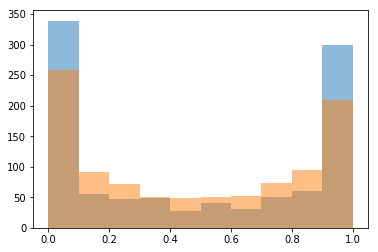

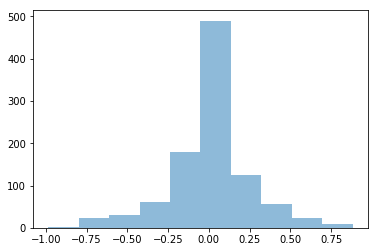

1000 x 1000
0.846 0.0 / 0.16250807 0.18573907


In [20]:
for tup in reportz:
#     tup = pickle.loads(zlib.decompress(tup_cmp))
    report(*tup)
    
# qws = reportz[0][7][0]
# real_qws = reportz[0][10][0]
# print(qws)
# numpy.set_printoptions(threshold=10000)
# print(real_qws)

# *****
# MLTM XENT
# 1 1 1 1 1 1 1
# params: 10 1 5 1 / 2.5806077740610034 2.347493116108512 [[ 0.821]] 0.459641891892 0.495
# R2 =  0.447788537896
# MAE =  0.204465762654
# 1000 x 150
# 0.749 0.0 / 0.204466 0.144075




In [ ]:
# sws2= s_table2.get_weights()[0]
# qws2= qn_table2.get_weights()[0]

# offset = numpy.mean(students2) - numpy.mean(sws2) 
# qws2 = qws2# + offset
# sws2 = sws2# + offset

bin_spread = lambda x: max(1,int(abs(2*(numpy.max(x)-numpy.min(x)))))

for ss in real_stu_list:
    plt.hist(ss.flatten(), alpha=0.2, bins=bin_spread(ss), label="s true")
# plt.legend()
# plt.show()

print("There are {} els in sws_list and {} els in qws_list".format(len(sws_list), len(qws_list)))

sw_av_list = []
for sw in sws_list:
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
    plt.hist(sw.flatten(), alpha=0.2, bins=bin_spread(sw), label="s pred")
    sw_av_list.append(numpy.median(sw.flatten()))
plt.legend()
plt.show()

for qnz in real_que_list:
    plt.hist(qnz.flatten(), alpha=0.2, label="q true", bins=bin_spread(questions))

# qws_list_2 = []
real_max_q = numpy.max(questions.flatten())
print("len qws_list", len(qws_list))

for qw in qws_list:#, sw_av_list):
    qw = copy.copy(qw)
    print("med",numpy.median(qw), "for shape", qw.shape)
#     (sz,qz,pfz), (vsz,vqz,vpfz), (tsz,tqz,tpfz) = tups
#     qg2 = (qg>0.5).astype(int)
#     masqd = qw*qg2
#     qws_list_2.append(masqd)
#     print(qw)
#     print(qg)
#     plt.hist(qw[list(set(qz))].flatten(), alpha=0.4, bins=bin_spread(qw)) 

#     max_q = numpy.max(qw)
#     os = real_max_q - max_q
#     qw += os

#     thresh = 0
#     qw[qw < thresh] = 0
    plt.hist(qw.flatten(), alpha=0.2, label="q pred", bins=bin_spread(qw))
plt.legend()
plt.show()


# qws_list = qws_list2

print(len(pred_list))
plt.hist(pfz, alpha=0.2, label="true obs")
plt.hist(probs.flatten(), alpha=0.3, label="true probs")
for ix,predz in enumerate(pred_list):
    plt.hist(predz, alpha=0.1, label=str(ix))
plt.legend()
plt.show()

In [ ]:
plot_items(qws_list[1:], qws_list[0], 0)

In [ ]:
for qw in qws_list:#, sw_av_list):
    print(qw)

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error
def report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
    
    tot_sqerr = 0
    mean_err_list = []
    mean_std_list = []
    mean_hit_list = []
    
    print("*****")
    print(nn_mode, loss_mode)
#     print("*****")
    print(len(sws_list), len(qws_list), len(model_list), len(real_stu_list), len(real_que_list), len(test_datasets), len(params_list))
    
    for sw,qw,m,stz,qnz,tt_pairs, params, spars in zip(sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list, spars_list):
        tw,a1,a0,trbal,vbal,agt = params
        
        print("params:", n_factors, min_active, max_active, emb_w, "/", tw,a1,a0, "(", trbal,vbal,agt,") [",spars,"]")
        
        err_list = []
        true_err_list = []
        hit_list = []
    #     for six,qix in numpy.sort(tt_pairs, axis=0):
    
        true_pz = []
        pred_pz = []
        for six, qix in tt_pairs:
    #         print(six, qix)
    #     print("\n------\n")
    #     continue
    #     if False:
            tq = qnz[qix,:]
            ts = stz[six,:]
            qrow = qw[qix, :]
            srow = sw[six, :]
#             print(qrow)
    #         print("raw",tq,ts)
    #         print("dif",ts-tq)
    #         print(numpy.prod(logistic(ts-tq,1,0)))
            if rasch:
                true_p = float(calc_probs_from_embs(ts.reshape(1,-1),tq.reshape(1,-1)))
#                 dif = ts-tq
#                 true_ps = 1.0 / (1.0 + numpy.exp(-dif))
#                 true_p = numpy.prod(true_ps)
            else:
                true_p = numpy.prod((1-tq)+(ts*tq))
            pred_p = m.predict([[qix],[six]])
            true_pz.append(float(true_p))
            pred_pz.append(float(pred_p))
    #         pred_p = random.random()
    
            mae = numpy.abs(true_p - pred_p)
#             print(true_p, float(pred_p), "err:", float(mae))

            err = true_p - pred_p

            true_err_list.append(err)
            err_list.append(mae)
            good_guess = int(numpy.round(true_p))==int(numpy.round(pred_p))
            hit_list.append(int(good_guess))
    #         sqerr = numpy.power(true_p - pred_p, 2)

#             print(six, qix, ":", srow, qrow)
#             print("-->", pred_p, true_p, " ... ", good_guess)

        print("R2 = ", r2_score(true_pz, pred_pz))
        print("MAE = ", mean_absolute_error(true_pz, pred_pz))
        numpy.set_printoptions(precision=3)
    #     print("Mean sq err {}:".format(qrow.shape), numpy.sqrt(numpy.mean(err_list)))
    
        plt.hist(true_pz, alpha=0.5)
        plt.hist(pred_pz, alpha=0.5)
        plt.show()
        
        plt.hist(numpy.array(true_err_list).flatten(), alpha=0.5)
        plt.show()
        
        mean_err_list.append(numpy.mean(err_list))
        mean_std_list.append(numpy.std(err_list))
        mean_hit_list.append(numpy.mean(hit_list))
    #     print(sum(hit_list), len(hit_list), sum(hit_list)/len(hit_list))

    # print(mean_err_list)
    # print(mean_std_list)
    # print(mean_hit_list)
    # print(params_list)
    print(len(stz),"x",len(qnz))
#     for e,s,acc,params in zip(mean_err_list, mean_std_list, mean_hit_list, params_list):
#         print("acc=",acc)
#         print("mae=",e,"sig=",s)
#         print(params)
#     print("aggregated:")
    print(numpy.median(mean_hit_list), numpy.std(mean_hit_list), "/", numpy.median(mean_err_list), numpy.median(mean_std_list))
    
report(n_factors, min_active, max_active, emb_w, nn_mode, loss_mode, sws_list, qws_list, model_list, real_stu_list, real_que_list, test_datasets, params_list)

TypeError: report() missing 1 required positional argument: 'spars_list'

In [ ]:
def mean_ensemble(ref, pred_list):
    summage = numpy.zeros_like(ref)
    for items in pred_list:
        items_aligned, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, ref, items, max_iter=10)        
        print("err", numpy.mean(numpy.abs(items_aligned - ref)))
        summage += items_aligned
    summage /= len(pred_list)
    print("ensem err", numpy.mean(numpy.abs(summage - ref)))
    return summage
#         for item, real_item in zip(items, real_items):
#             print(numpy.sort(real_item))
#             print(numpy.sort(item))
#             print()
            

mean_en = mean_ensemble(qws_list[0], qws_list[1:])
plot_items([], questions, None)
plot_items(qws_list, mean_en, 0)


In [ ]:
print(m_list)
for m,tr in zip(m_list, tr_list):
    (sz2,qz2,pfz2), (vsz2,vqz2,vpfz2), (tsz2,tqz2,tpfz2) = tr
    print(sz2,qz2,pfz2)
    print(vsz2,vqz2,vpfz2)
    print(tsz2,tqz2,tpfz2)
    preds = m.predict(x=[qz2,sz2])
    for sc_true, sc_hat in zip(pfz2,preds):
        print(sc_true, sc_hat)

    # print(m.evaluate(x=[mz,vz], y=scz))
    from sklearn.metrics import mean_absolute_error, mean_absolute_error
    print(mean_absolute_error(numpy.around(pfz2), numpy.around(preds)  ))
    
plt.hist(pfz2)
plt.show()
plt.hist(preds)
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping
min_loss = math.inf
min_v_loss = math.inf
init_patience = 5
for i in range(100):
    print("shiteration i=",i)
    h = m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=2, shuffle=True, validation_split=1000/len(scz), verbose=1)
    val_loss = h.history["val_loss"][-1]
    loss = h.history["loss"][-1]
    if loss < min_loss and val_loss <= min_v_loss:
        min_v_loss = val_loss
        min_loss = loss
        print("patience reset")
        patience = init_patience
#         sw = s_table.get_weights()
#         qw = qn_table.get_weights()
    else:
        patience -= 1
    if patience==0:
        print("DONE")
        break
#     m.fit(x=[mz,vz], y=numpy.array([(0.5+random.uniform(-0.5,0.5)) for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=10, verbose=0)
    m.fit(x=[mz,vz], y=numpy.array([0.5 for _ in scz]).reshape(-1,1), batch_size=1000, shuffle=False, epochs=2, verbose=0)
    
# s_table.set_weights(sw)
# qn_table.set_weights(qw)

In [ ]:
es = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
m.fit(x=[mz,vz], y=scz, batch_size=1000, epochs=100, validation_split=1000/len(scz))#, callbacks=[es])

In [ ]:
preds = m.predict(x=[tmz,tvz])
for p, sc_obsv, sc_hat in zip(t_probz, tscz,preds):
    print(p, sc_obsv, sc_hat, (numpy.around(sc_obsv)==numpy.around(sc_hat)))

# print(m.evaluate(x=[tmz,tvz], y=tscz))
from sklearn.metrics import accuracy_score, mean_absolute_error

print("obvsd acc", accuracy_score(numpy.around(tscz), numpy.around(preds)))
print("non-stoch acc", accuracy_score(numpy.around(t_probz), numpy.around(preds)))
print(mean_absolute_error(t_probz, preds))
#0.000302638761699 MSE MxMul


In [ ]:
    plt.hist(obs.flatten())
    plt.show()
    print(numpy.sum(numpy.around(obs)))
    print(len(obs.flatten()))
    

In [ ]:
pred_wgts = qn_table.get_weights()[0]
real_wgts = movies

split = 0

items_chosen, min_total_err, total_q_err, total_s_err, mean_ll, best_cos_dis = calc_arr_arr_err(0, real_wgts, pred_wgts, max_iter=10)

In [ ]:
print(min_total_err, total_q_err, total_s_err)

print(items_chosen)



In [ ]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

pca = PCA(n_components=2)
# pca = TSNE(n_components=2)

itemz_pred = items_chosen
n = len(items_chosen)
itemz = movies

# s_pred_mean = numpy.mean(s_table.get_weights()[0])
base = min( numpy.min(itemz_pred), numpy.min(itemz))
# ss1 = StandardScaler()
# itemz_pred = ss1.fit_transform(itemz_pred)
# itemz = ss1.transform(movies)

itemz = itemz - base
itemz_pred = itemz_pred - base

print(itemz)
print(itemz_pred)

In [ ]:
# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
# itemz_2 = itemz
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

fig.show()

In [ ]:
numpy.set_printoptions(precision=2, suppress=True, threshold=100)
def create_adj_mx(nodes):
    L = numpy.zeros((len(nodes), len(nodes)))
    for i in range(len(nodes)):
        sum_dist = 0
        for j in range(len(nodes)):
            dist = numpy.linalg.norm(nodes[j]-nodes[i], ord=2)
            L[i,j] = dist
    return L

def create_laplacian(nodes):
    amx = create_adj_mx(nodes)
    L = -amx #negate the adj mx
    for ix,row in enumerate(L):
        deg = -numpy.sum(row)
        L[ix,ix] = deg
    return L

def graph_adj_mx(L, n=3, fn="adj_mx"):
    from graphviz import Graph
    gg = Graph(strict=True, filename=fn)
    if L[0,1]<0:
        L = -L
    for ix in range(len(L)):
        row = L[ix,:]
        js = numpy.argsort(row)[1:n+1]
        for j in js:
            v = row[j]
            tup = str(ix),str(j),str(round(v,2))
#             print("cadd edge", tup)
            sta,end,lab = tup
            gg.edge(sta,end, label=str(lab))
    gg.view()


amx = create_adj_mx(questions)
print(amx)
graph_adj_mx(amx)

    
# numpy.set_printoptions(precision=2, suppress=True, threshold=100000)
# print(L0.argsort(axis=1))
m=3
L1 = create_laplacian(questions)
print(L1)
graph_adj_mx(L1, fn="original", n=m)

for j,q in enumerate(qws_list):
    L1 = create_laplacian(q)
    graph_adj_mx(L1, fn="facsimile_{}".format(j), n=m)

# lams = numpy.linalg.eigvalsh(L0)
# sum_eig = sum(lams)
# sum_upto = 0
# ct=0
# for lam in lams:
#     sum_upto += lam
#     if sum_upto > 0.9*sum_eig:
#         print("broke loop at \lambda_{}".format(ct))
#         break
#     ct+=1